# TP I : Descentes de Gradient

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations des descentes de gradients. **C'est un *TP à trous* ; il s'agira de compléter ces trous et d'y ajouter les tests qui vous sembleront utiles.**

Voici un aperçu des points abordés lors de ce TP.

- partie I
    - Définition d'un ensemble de fonctions test
- partie II
    - Calcul du gradient d'une fonction de manière approchée (pour couvrir des cas où le calcul explicite du gradient est impossible ou pénible).
- partie III
    - La descente dans la direction du Gradient à pas constant
    - Optimisation du pas par Backtracking
- partie IV
    - Choix d'une autre direction que le gradient
        - De plus forte pente en norme $l_1$
        - Gradient conjugué
- partie V
    - Accélération : Momentum, Nesterov, Adam.
- partie VI
    - La Méthode de Newton et la méthode de quasi-Newton

    
Dans l'ensemble du déroulé du TP vous ferez bien attention à valider par un jeu de tests la validité des programmes écrits. Vous regarderez l'influence des paramètres sur la convergence. Vous comparerez les intérêts des diférentes méthodes les unes par rapport aux autres.

**Pour ceux qui souhaiteront choisir ce TP comme base de la note finale, votre démarche et vos conclusions seront présentées sous forme d'un rapport (de 5 à 10 pages) où vous pourrez choisir d'avoir une approche plus sur les résultats mathématiques ou sur les résultats numériques. Le notebook Jupiter avec l'ensemble de vos travaux sera aussi remis. Ces deux éléments devront être remis au plus tard le mercredi 29 juin.**


## Attendus de rendu

Votre rendu sera jugé à l'aune de

- votre capacité à produire des algorithmes valides, répondant à la question posée
- l'étude effectuée concernant la sensibilité de vos algorithmes aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- les stress-tests auxquels vous aurez confrontés vos implémentations. 

On portera une attention particulière à la *généricité* de votre réponse ; tout comme cela vous est suggéré par la suite on attendra de vous d'appuyer vos affirmations par suffisamment de tests et une appréciation pour les limites de votre analyse.

Ce TP est à rendre par **groupes de 3** et exceptionnellement **2**.

# Au travail!

In [2]:
import warnings
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## I- Un set de fonctions tests

Cette partie ne nécessite pas de travail de votre part

Nous allons ici introduire quelques fonctions test qui permettent de représenter les situations suivantes:
- Fonctions globalement convexes ou uniquement localement convexes
- Fonctions admettant ou non un minimum global
- Fonctions admettant ou non des minimums locaux

Nous partons de fonctions définies sur $\mathbb{R}$ mais on verra que cela permet de définir des fonctions "intéressantes" sur $\mathbb{R}^n$.

### Fonctions du set de test

#### 1. Définir des familles de fonctions *convexes* sur $\mathbb{R}$  ou sur une partie de $\mathbb{R}$ ayant un nombre de conditionnement uniquement dépendant des paramètres de la famille.  

In [3]:
def quadratic1_(x,gamma):
        return gamma*(x**2) + x + 1 #valeur de la fonction

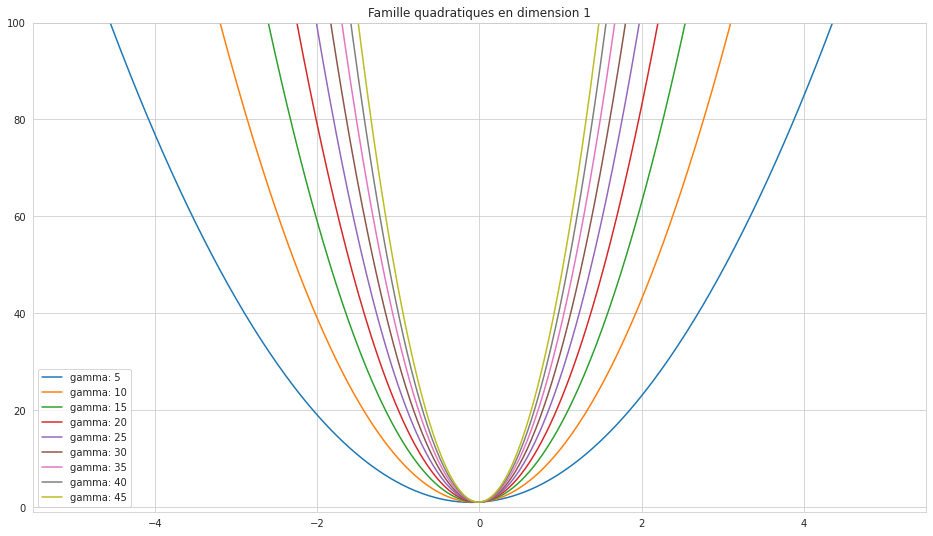

In [4]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-5, 5, 400)
ax.set_ylim(-1, 100)
for gamma in range(5, 50, 5):
    ax.plot(x, quadratic1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille quadratiques en dimension 1")
ax.legend()
plt.show()

In [5]:
def cubic1_(x,gamma):
        return x**3 + gamma*x**2 + x + 1 #valeur de la fonction

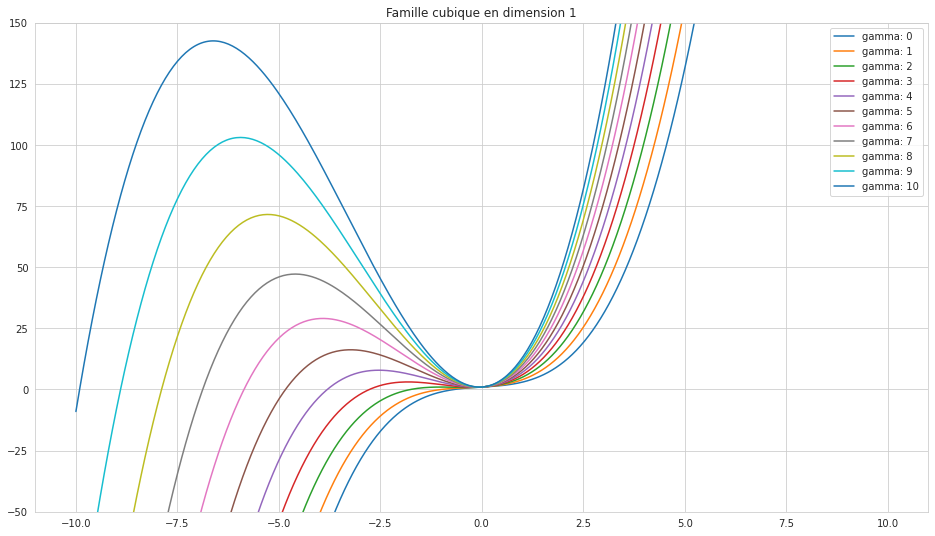

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 150)
for gamma in range(0, 11, 1):
    ax.plot(x, cubic1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille cubique en dimension 1")
ax.legend()
plt.show()

In [7]:
def multitrous1_(x,gamma):
        return 20*np.cos(x**2) + (gamma * x**2) #valeur de la fonction

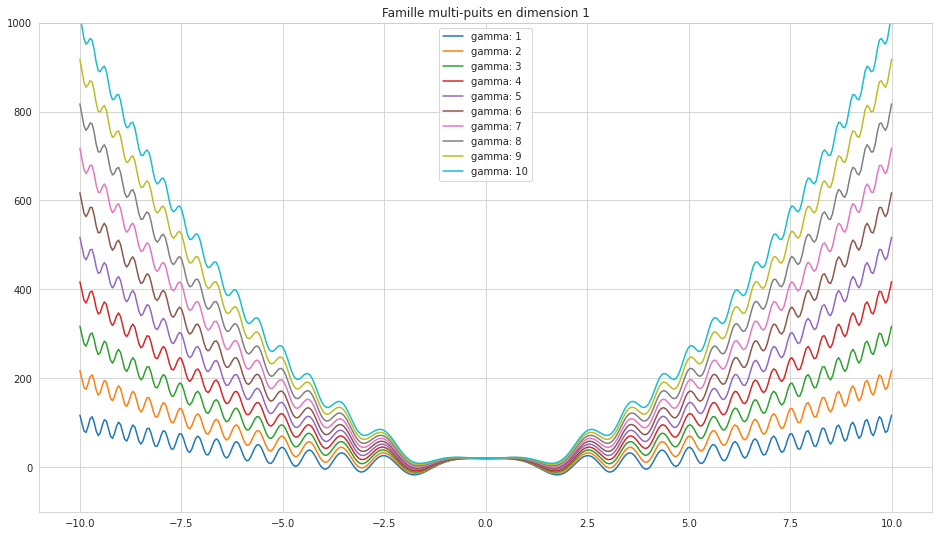

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-100, 1000)
for gamma in range(1, 11, 1):
    ax.plot(x, multitrous1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille multi-puits en dimension 1")
ax.legend()
plt.show()

#### 2. Faire de même avec des fonctions sur $\mathbb{R}^2$.

In [9]:
def quadratic2_(x,gamma):
        return quadratic1_(x[0],gamma[0])+quadratic1_(x[1],gamma[1]) #valeur de la fonction


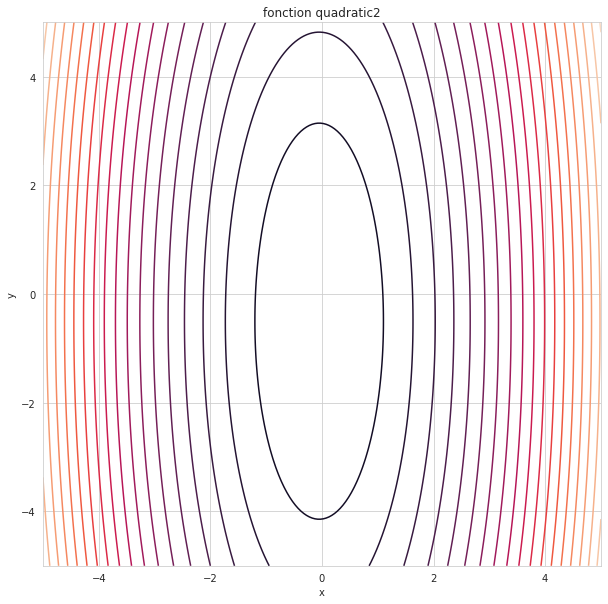

In [10]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -5, 5, -5, 5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

gamma=np.zeros(2)
gamma[0]=10
gamma[1]=1

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadratic2_(np.array([X[i,j],Y[i,j]]),gamma)

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,20) 
  
ax.set_title('fonction quadratic2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()



In [11]:
def cubic2_(x,gamma=10):
        return cubic1_(x[0],gamma)+cubic1_(x[1],gamma) #valeur de la fonction ou de son grad


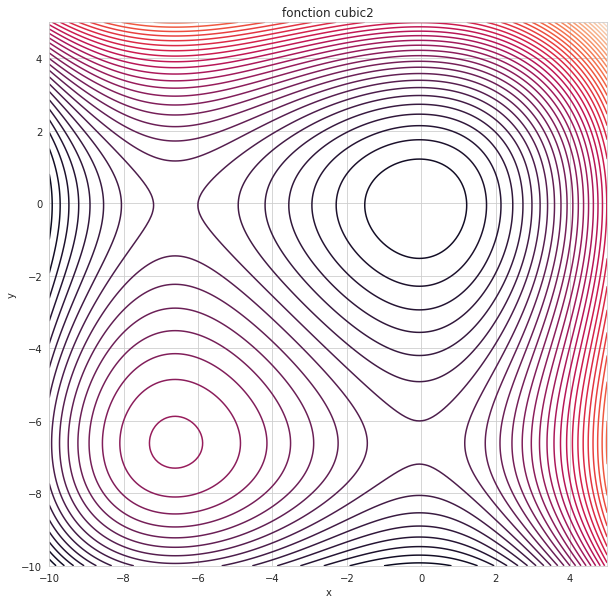

In [12]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -10, 5, -10, 5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)


Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=cubic2_(np.array([X[i,j],Y[i,j]]))


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,50) 
  
ax.set_title('fonction cubic2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()




In [13]:
def multitrous2_(x,gamma=4):
        return multitrous1_(x[0],1)+multitrous1_(x[1],gamma) #valeur de la fonction


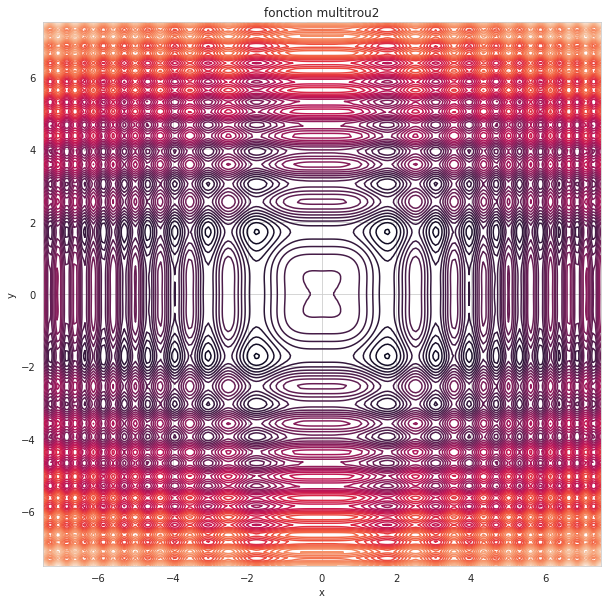

In [14]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -7.5, 7.5, -7.5, 7.5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)


Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=multitrous2_(np.array([X[i,j],Y[i,j]]))


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,50) 
  
ax.set_title('fonction multitrou2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()


#### 3. On construit ici une fonction convexe en dimension n

On va prendre comme fonction test la fonction convexe "générique" dans $\mathbb{R}^n$, $ x \mapsto \frac{1}{2}x^T A x-b^Tx$, 

où A est une matrice symétrique définie positive de taille $(n,n)$ et $b$ un vecteur de $\mathbb{R}^n$.

On a vu en cours que cette fonction est convexe, qu'elle admet donc un minimum global sur $\mathbb{R}^n$, et que ce minimum est atteint au point où son gradient s'annule, c'est à dire au point où $Ax=b$.


Une manière commode de construire une matrice $A$ symétrique définie positive est de la voir comme une matrice de la forme $A=U^T U$ avec $U$ triangulaire supérieure car cela nous permet  à la fois de s'assurer qu'elle est symétrique, inversible, positive et en plus de "contrôler" les valeurs propres de $A$ et donc son conditionnement.
Le conditionnement de $A$ est le rapport entre la plus grande et la plus petite de ses valeurs propres. C'est le carré du rapport entre la plus grande et la plus petite des valeurs propres de $U$ qu'on trouve sur la diagonale.


In [15]:
def create_system (dim,cond=10,seed=100):
    np.random.seed(seed)
    A=0.1*np.random.uniform(-math.sqrt(cond),math.sqrt(cond),size=(dim,dim))
    A=np.triu(A)
    # on remplace la diagonale de A par des valeurs aléatoires positives entre 1 et sqrt(cond)
    A=A-np.diag(np.diag(A))+np.diag(np.random.uniform(1.,math.sqrt(cond),size=(dim))) 
    # on impose les deux premiers termes de la diagonale diagonale de A pour fixer le conditionnement
    A[0,0]=1.
    A[1,1]=math.sqrt(cond)
    b=1.*np.random.randint(-10,10,size=(dim))
    A=A.T @ A
    return A,b

In [16]:
A,b = create_system(5,cond=10)
print (A,b)

[[ 1.         -0.14017151 -0.04773927  0.21805557 -0.3132433 ]
 [-0.14017151 10.01964805  0.6583972  -0.757152    0.19409444]
 [-0.04773927  0.6583972   2.43429773 -0.44063605 -0.24929874]
 [ 0.21805557 -0.757152   -0.44063605  7.56250011 -0.42402717]
 [-0.3132433   0.19409444 -0.24929874 -0.42402717  1.21928084]] [ 4.  7.  6.  5. -3.]


In [17]:
def quadraticn_(x):
        return (x.T@A@x)/2-b.T@x #valeur de la fonction


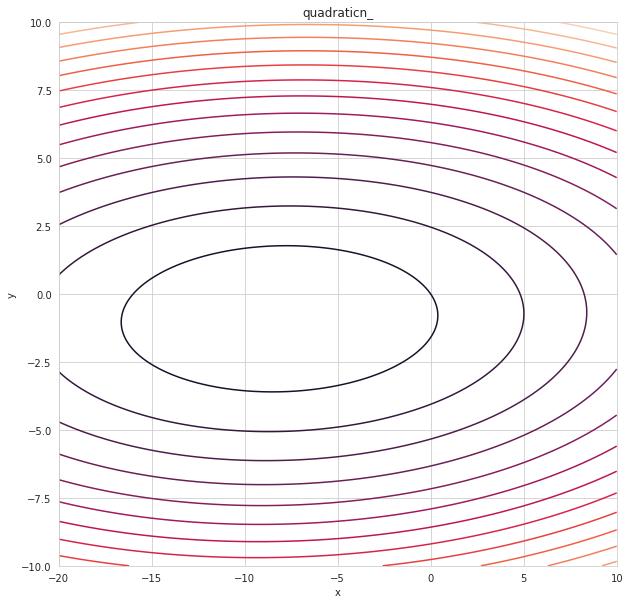

In [18]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -20, 10, -10, 10

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

dim=2
A,b = create_system(dim,cond=10)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,15) 
  
ax.set_title('quadraticn_') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()


#### 4. La banane de Rosenbrock

Voici une fonction célèbre pour tester les algorithmes d'optimisation.

$$f(x,y)=(x-1)^2+\gamma (x^2-y)^2$$

Ce n'est pas évident à visualiser mais cette fonction présente un minimum global unique qui se situe au fond d'une vallée très étroite et en forme de parabole.


In [19]:
def Rosenbrock(x,gamma=100):
        return (x[0]-1)**2+gamma*(x[0]**2-x[1])**2 #valeur de la fonction


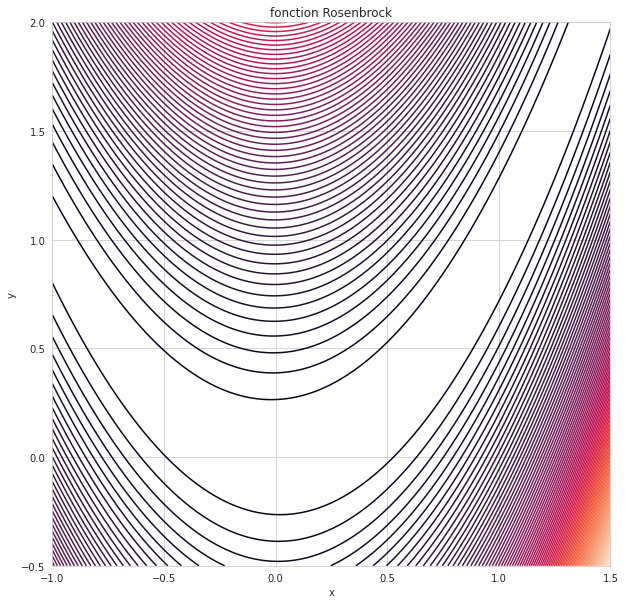

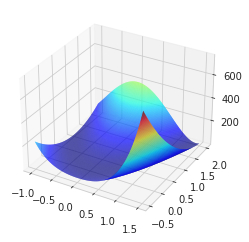

In [20]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -1, 1.5, -0.5, 2
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=Rosenbrock(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,100) 
  
ax.set_title('fonction Rosenbrock') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
cmap='jet', edgecolor='none')

### Conclusion

On voit sur ces quelques exemples que des fonctions d'apparence "innofensives" peuvent avoir des comportements complexes en ce qui concerne leurs extrema locaux ou globaux.

${\bf Nous \, vous \, invitons \, à \, tester}$ les programmes que vous écrirez:
* sur la fonction quadratique pour la dimension n=2 puis n=10, et pour des conditionnements variant de 5 à 1000.
* sur la fonction de Rosenbrock pour des valeurs de gamma variant de 5 à 100

## II- Différencier une fonction numériquement

On verra aussi comment calculer le gradient de manière approchée. Cela est particulièrement utile quand la seule information disponible sur la fonction à minimiser est sa valeur en tout point.

Pour calculer le gradient d'une fonction on a déjà besoin de savoir calculer la dérivée d'une fonction réelle, et on en tire ensuite une version numérique du gradient.

### Le calcul numérique de la dérivée

Pour $h$ assez petit on peut approcher $f'(x)$ par 
$$ f'(x) \simeq \frac{f(x + h) - f(x)}{h} $$
L'erreur de l'approximation est en $o(1)$ quand $h \to 0$. 

$$ $$
On peut en réalité faire un peu mieux en approchant $f'(x)$ par 
$$f'(x) \simeq \frac{f(x+h)-f(x-h)}{2h}$$
On trouve que l'erreur d'approximation dans le second cas est désormais en $o(h)$ quand $h \to 0$; ce qui est a priori meilleur.

#### 1. Utiliser la démarche précédente pour approcher la dérivée partielle d'une fonction en un point. Cette fonction sera notée `partial`.

In [21]:
def partial(f, x, i=0, dx=1e-8):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    h = np.zeros(x.size)
    h[i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

#### 2. Comparer `partial` à l'expression exacte de la dérivée partielle d'une fonction de votre choix. 

In [22]:
partial(lambda x: np.exp(x), np.array([100]))

array([2.68811544e+43])

In [23]:
np.exp(np.array([100]))

array([2.68811714e+43])

### Le calcul du gradient

Comme dit précédemment, comme le calcul exact du gradient n'est parfois pas possible ou facile, on se garde la possibilité de calculer numériquement le gradient d'une fonction.

#### 1. Écrire une fonction `gradient` qui renvoie le gradient d'une fonction en un point grâce à la fonction précédente

In [24]:
def gradient(f, x, dx=1e-8):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    return np.array([partial(f, x, i, dx=dx) for i in range(x.shape[0])])

#### 2. Tester cette fonction gradient sur une fonction connue.

In [25]:
x=np.zeros(2)
x[0]=1
x[1]=10
gradient(lambda x: x[0]**5 + x[1]**2, x)

array([ 4.9999997 , 20.00000165])

## III- Descente du gradient

Tout d'abord, nous allons implémenter des descentes qui se feront dans la direction du Gradient


### le cas générique de descente de gradient avec un pas constant


* prendre un point de départ au hasard ${\bf p_0}$.

Quand on est au point ${\bf p_k}$

* calculer le gradient de J en ce point $\nabla J({\bf p_k})$

* On choisit une direction de descente ${\bf d}_k = - \nabla J({\bf p}_k)$

* avancer dans cette direction : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

et on recommence cette dernière étape jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\mu$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouver piégé dans des boucles infinies !!!

#### 1. Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\mu$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouvé piégé dans des boucles infinies !!!
On conseille de stocker les différentes valeurs calculées pour les points ${\bf p_k}$ afin de pouvoir "regarder" la manière dont la convergence se passe.

In [26]:
def desc_grad_const(f, p0, mu=0.001, eps=1E-6):
    """
    Description: 
    Parameters:
    p0: point initial
    f: fonction à minimiser
    mu: valeur constante du pas (0.001 par défaut)
    eps: critère à partir duquel on considèrera que la suite est "constante"
    
    Output
    Tableau contenant l'ensemble des positions successives p_k
    """
    max_iter = 10000
    iter = 1
    points = [p0]
    grad = gradient(f, p0)
    d = -grad
    pk = p0
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and iter < max_iter:
        pk = pk_1
        points.append(pk)
        grad = gradient(f, pk)
        d = -grad
        pk_1 = pk + mu * d
        iter += 1
    return points

In [33]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim","mu", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for mu in [1, 0.8, 0.5, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001]:
                t0 = time.time()
                res = gd(f, x0, mu)
                gd_time = time.time() - t0
                res = np.array(res, dtype=object)
                error = np.linalg.norm(res[-1] - x_exact)
                df_GD.loc[f"{f_name}_{dim}_{mu}"] = pd.Series({
                    "dim": dim,
                    "mu": mu,
                    "nb_iter": len(res),
                    "error": error if error < 1E5 else math.inf,
                    "time" : gd_time
                })
display(df_GD)

dim     mu  nb_iter         error      time
quadraticn__2_1        2.0  1.000  10000.0           inf  0.755409
quadraticn__2_0.8      2.0  0.800  10000.0           inf  0.735151
quadraticn__2_0.5      2.0  0.500     22.0  7.611677e-07  0.001835
quadraticn__2_0.1      2.0  0.100    111.0  9.957572e-06  0.007925
quadraticn__2_0.05     2.0  0.050    214.0  1.928803e-05  0.014238
quadraticn__2_0.02     2.0  0.020    495.0  4.948775e-05  0.032738
quadraticn__2_0.01     2.0  0.010    924.0  9.980071e-05  0.060853
quadraticn__2_0.005    2.0  0.005   1712.0  2.005490e-04  0.112239
quadraticn__2_0.001    2.0  0.001   6960.0  1.002493e-03  0.466529
quadraticn__10_1      10.0  1.000     23.0           inf  0.006826
quadraticn__10_0.8    10.0  0.800     34.0           inf  0.009684
quadraticn__10_0.5    10.0  0.500     56.0  4.634269e-07  0.014574
quadraticn__10_0.1    10.0  0.100    117.0  1.063050e-05  0.029987
quadraticn__10_0.05   10.0  0.050    224.0  2.141759e-05  0.056895
quadraticn__10_0.02   10.0  0.020    518.0  5.311507e-05  0.130768
quadraticn__10_0.01   10.0  0.010    965.0  1.067931e-04  0.242608
quadraticn__10_0.005  10.0  0.005   1784.0  2.143195e-04  0.369876
quadraticn__10_0.001  10.0  0.001   7218.0  1.063334e-03  1.418617
Rosenbrock_2_1         2.0  1.000      4.0           inf  0.001397
Rosenbrock_2_0.8       2.0  0.800      4.0           inf  0.000232
Rosenbrock_2_0.5       2.0  0.500      4.0           inf  0.000286
Rosenbrock_2_0.1       2.0  0.100      6.0           inf  0.000309
Rosenbrock_2_0.05      2.0  0.050      7.0           inf  0.000367
Rosenbrock_2_0.02      2.0  0.020     12.0           inf  0.000570
Rosenbrock_2_0.01      2.0  0.010     39.0           inf  0.001728
Rosenbrock_2_0.005     2.0  0.005  10000.0  8.937283e-01  0.412717
Rosenbrock_2_0.001     2.0  0.001  10000.0  1.251696e-02  0.320686

#### 2. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [106]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_grad_const(quadraticn_,x0,mu=0.01)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 974
x_calculé [0.9998899961891261 1.0000001883986829 1.0000003733513392
 1.0000045971195557 0.9999978044773228 0.9999987832784334
 1.0000006994753612 1.0000006710735845 0.9999989325267771 1.00000402339903]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 1ère amélioration: le choix d'un pas "optimal" à chaque étape par *backtracking* (ou rebroussement avec critère d'Armijo)

Vous devriez avoir constatés que le choix du pas de descente dans le cas constant est crucial pour garantir la convergence de l'algorithme de descente. Dans cette section on s'intéresse à un calcul adaptatif du pas de descente qui permet de mieux garantir la convergence de notre algo. Le désavantage est le temps que prend désormais chaque itération pour s'exécuter.


Ici on veut imposer la décroissance de la suite $J({\bf p}_k)$ ce qui nous assurera la convergence. Mais pour assurer la convergence vers un minimum, il faut imposer un peu plus que simplement de descendre, c'est ce que traduit le critère d'Armijo.

On prend ici deux paramètres $0<\alpha<0.5$ et $0<\beta<1$.

On cherche un $\mu$ qui vérifie:
$$ J({\bf p}_k+\mu {\bf d}_k) < J({\bf p}_k) + \alpha \, \mu \, {\bf d}_k ^T \, \nabla J({\bf p}_k)\quad (1).$$

On a vu en cours q'un tel $\mu$ existe dès que ${\bf d}_k$ est une direction de descente (c'est à dire dès que ${\bf d}_k ^T \, \nabla J({\bf p}_k) \, <\, 0$.

* On part de $\mu = 1$

* si la condition $(1)$ ci-dessus est vérifiée on choisit cette valeur de $\mu$

* sinon on change $\mu$ en $\beta \, \mu$

Et on recommence jusqu'à ce que la condition $(1)$ soit vérifiée.




#### 1. Écrire une fonction `backtracking` qui permet de calculer le pas par *backtracking* avec critère d'Armijo à une itération donnée. Pour rappel le *backtracking* a deux hyper-paramètre $\alpha$ et $\beta$ que vous mettrez par défaut à $0.4$ et $0.8$.

In [59]:
# Cette fonction génère la taille du pas optimal vérifiant le critère d'Amijo

def backtrack(x0, f , dir_x, alpha = 0.4, beta = 0.8):
    """
    Description: 
    Parameters:
    x0: point actuel
    f: fonction à minimiser
    dir_x: direction dans laquelle on souhaite aller
    
    Output
    valeur du pas optimal
    """
    max_iter = 10000
    iter = 1
    mu = 1
    pk = x0
    grad = gradient(f, pk)
    while f(pk + mu * dir_x) >= f(pk) + alpha * mu * grad @ dir_x.T and iter < max_iter:
        mu = beta * mu
        iter += 1
    return mu

La méthode est donc très analogue à la précédente

* prendre un point de départ au hasard ${\bf p_0}$.

Quand on est au point ${\bf p_k}$

* Calculer le gradient de J en ce point $\nabla J({\bf p_k})$

* Choisir une direction de descente ${\bf d}_k = - \nabla J({\bf p}_k)$

* Trouver $\mu_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

#### 2. Implémenter cette méthode

In [60]:
def desc_grad_opti(f,p0,eps=1E-6, alpha=0.4, beta=0.8):
    max_iter = 10000
    iter = 1
    points = [p0]
    grad = gradient(f, p0)
    d = -grad
    pk = p0
    mu = backtrack(pk, f, d, alpha, beta)
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and iter < max_iter:
        pk = pk_1
        points.append(pk)
        grad = gradient(f, pk)
        d = -grad
        mu = backtrack(pk, f, d)
        pk_1 = pk + mu * d
        iter += 1
    return points

#### 3. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [61]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_grad_opti(quadraticn_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 602
x_calculé [0.99995259 1.00000035 1.00000017 1.00000205 0.99999912 0.99999956
 1.00000036 1.00000008 0.99999978 1.00000174]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [62]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_grad_opti(lambda x : Rosenbrock(x, gamma=100),x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 7035
x_calculé [0.99956332 0.99912619]
x_exact [1. 1.]


In [63]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim", "alpha", "beta", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for alpha in np.arange(0.1, 0.5, 0.1):
                for beta in np.arange(0.1, 1.0, 0.1):
                    t0 = time.time()
                    res = gd(f, x0, alpha, beta)
                    gd_time = time.time() - t0
                    res = np.array(res, dtype=object)
                    error = np.linalg.norm(res[-1] - x_exact)
                    df_GD.loc[f"{f_name}_{dim}_{round(alpha, 2)}_{round(beta, 2)}"] = pd.Series({
                        "dim": dim,
                        "alpha": alpha,
                        "beta": beta,
                        "nb_iter": len(res),
                        "error": error if error < 1E5 else math.inf,
                        "time" : gd_time
                    })
display(df_GD)

dim  alpha  beta  nb_iter     error      time
quadraticn__2_0.1_0.1    2.0    0.1   0.1      4.0  0.025150  0.004043
quadraticn__2_0.1_0.2    2.0    0.1   0.2      5.0  0.080167  0.000737
quadraticn__2_0.1_0.3    2.0    0.1   0.3      5.0  0.080167  0.000815
quadraticn__2_0.1_0.4    2.0    0.1   0.4      5.0  0.080167  0.012728
quadraticn__2_0.1_0.5    2.0    0.1   0.5      3.0  0.027236  0.001270
quadraticn__2_0.1_0.6    2.0    0.1   0.6      5.0  0.071828  0.001640
quadraticn__2_0.1_0.7    2.0    0.1   0.7      5.0  0.079003  0.001398
quadraticn__2_0.1_0.8    2.0    0.1   0.8      5.0  0.117365  0.003682
quadraticn__2_0.1_0.9    2.0    0.1   0.9      6.0  0.072660  0.002397
quadraticn__2_0.2_0.1    2.0    0.2   0.1      4.0  0.025150  0.014677
quadraticn__2_0.2_0.2    2.0    0.2   0.2      4.0  0.160895  0.000719
quadraticn__2_0.2_0.3    2.0    0.2   0.3      4.0  0.160895  0.006561
quadraticn__2_0.2_0.4    2.0    0.2   0.4      4.0  0.160895  0.001386
quadraticn__2_0.2_0.5    2.0    0.2   0.5      3.0  0.027236  0.000941
quadraticn__2_0.2_0.6    2.0    0.2   0.6      4.0  0.169770  0.001296
quadraticn__2_0.2_0.7    2.0    0.2   0.7      5.0  0.079003  0.001583
quadraticn__2_0.2_0.8    2.0    0.2   0.8      4.0  0.228486  0.001459
quadraticn__2_0.2_0.9    2.0    0.2   0.9      5.0  0.146444  0.001732
quadraticn__2_0.3_0.1    2.0    0.3   0.1      3.0  0.253083  0.000831
quadraticn__2_0.3_0.2    2.0    0.3   0.2      3.0  0.323791  0.000957
quadraticn__2_0.3_0.3    2.0    0.3   0.3      3.0  0.323791  0.000977
quadraticn__2_0.3_0.4    2.0    0.3   0.4      3.0  0.323791  0.002110
quadraticn__2_0.3_0.5    2.0    0.3   0.5      3.0  0.027236  0.001015
quadraticn__2_0.3_0.6    2.0    0.3   0.6      3.0  0.334990  0.001171
quadraticn__2_0.3_0.7    2.0    0.3   0.7      3.0  0.445049  0.001052
quadraticn__2_0.3_0.8    2.0    0.3   0.8      4.0  0.228486  0.001304
quadraticn__2_0.3_0.9    2.0    0.3   0.9      1.0  1.414214  0.000601
quadraticn__2_0.4_0.1    2.0    0.4   0.1      3.0  0.253083  0.000716
quadraticn__2_0.4_0.2    2.0    0.4   0.2      3.0  0.323791  0.001030
quadraticn__2_0.4_0.3    2.0    0.4   0.3      3.0  0.323791  0.000841
quadraticn__2_0.4_0.4    2.0    0.4   0.4      3.0  0.323791  0.004946
quadraticn__2_0.4_0.5    2.0    0.4   0.5      3.0  0.027236  0.000922
quadraticn__2_0.4_0.6    2.0    0.4   0.6      3.0  0.334990  0.000891
quadraticn__2_0.4_0.7    2.0    0.4   0.7      3.0  0.445049  0.003119
quadraticn__2_0.4_0.8    2.0    0.4   0.8      4.0  0.228486  0.001367
quadraticn__2_0.4_0.9    2.0    0.4   0.9      1.0  1.414214  0.000630
quadraticn__10_0.1_0.1  10.0    0.1   0.1      5.0  0.105990  0.006739
quadraticn__10_0.1_0.2  10.0    0.1   0.2      5.0  0.105990  0.003474
quadraticn__10_0.1_0.3  10.0    0.1   0.3      5.0  0.097998  0.003414
quadraticn__10_0.1_0.4  10.0    0.1   0.4      5.0  0.097998  0.005894
quadraticn__10_0.1_0.5  10.0    0.1   0.5      5.0  0.097785  0.003552
quadraticn__10_0.1_0.6  10.0    0.1   0.6      5.0  0.105990  0.013187
quadraticn__10_0.1_0.7  10.0    0.1   0.7      5.0  0.148578  0.003605
quadraticn__10_0.1_0.8  10.0    0.1   0.8      6.0  0.098428  0.004636
quadraticn__10_0.1_0.9  10.0    0.1   0.9      6.0  0.119960  0.016917
quadraticn__10_0.2_0.1  10.0    0.2   0.1      4.0  0.186704  0.004092
quadraticn__10_0.2_0.2  10.0    0.2   0.2      4.0  0.186704  0.003548
quadraticn__10_0.2_0.3  10.0    0.2   0.3      4.0  0.182786  0.001885
quadraticn__10_0.2_0.4  10.0    0.2   0.4      4.0  0.182786  0.003324
quadraticn__10_0.2_0.5  10.0    0.2   0.5      5.0  0.097785  0.004181
quadraticn__10_0.2_0.6  10.0    0.2   0.6      4.0  0.186704  0.002929
quadraticn__10_0.2_0.7  10.0    0.2   0.7      5.0  0.148578  0.003557
quadraticn__10_0.2_0.8  10.0    0.2   0.8      5.0  0.167725  0.005816
quadraticn__10_0.2_0.9  10.0    0.2   0.9      5.0  0.216107  0.002442
quadraticn__10_0.3_0.1  10.0    0.3   0.1      4.0  0.186704  0.001728
quadraticn__10_0.3_0.2  10.0    0.3   0.2      4.

#### 4. Comparer la descente par backtracking et la descente à pas constant (à vous de réfléchir à ce que vous voulez comparer).

In [64]:
dim = 10
desc_f = (desc_grad_const, desc_grad_opti)
x_exact=np.zeros(dim)+1.
x0=np.zeros(dim)
conds = [5,10,50,100,500]
gammas = [5,10,50,100]

res_quad = []
res_banana = []
for method in desc_f:
    res = []
    for cond_i in conds:
        A,b = create_system(dim, cond_i)
        b = A@x_exact
        desc = method(quadraticn_, x0)
        res.append((len(desc), desc[-1]))
    res_quad.append(res)
    
    res = []
    for gamma_i in gammas:
        desc = method(lambda x : Rosenbrock(x, gamma=gamma_i), x0)
        res.append((len(desc), desc[-1]))
    res_banana.append(res)

In [65]:
print("-- Fonction quadratic --")
print("Voici la différence entre les nombre d'itérations en fonction de la valeur de condition:")
print("\nPour la descente à pas constant:")
for i in range(0, 5):
    print("Avec comme condition", conds[i], "il a fallu ", res_quad[0][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_quad[0][i][0] == 10000 else "")

print("\nPour la descente avec backtracking:")
for i in range(0, 5):
    print("Avec comme condition", conds[i], "il a fallu ", res_quad[1][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_quad[1][i][0] == 10000 else "")

-- Fonction quadratic --
Voici la différence entre les nombre d'itérations en fonction de la valeur de condition:

Pour la descente à pas constant:
Avec comme condition 5 il a fallu  7186 
Avec comme condition 10 il a fallu  7200 
Avec comme condition 50 il a fallu  7271 
Avec comme condition 100 il a fallu  7306 
Avec comme condition 500 il a fallu  7388 

Pour la descente avec backtracking:
Avec comme condition 5 il a fallu  40 
Avec comme condition 10 il a fallu  77 
Avec comme condition 50 il a fallu  319 
Avec comme condition 100 il a fallu  602 
Avec comme condition 500 il a fallu  2416 


In [66]:
print("-- Fonction Rosenbrock --")
print("Voici la différence entre les nombre d'itérations en fonction de la valeur de gamma:")
print("\nPour la descente à pas constant:")
for i in range(0, 4):
    print("Avec comme gamma", gammas[i], "il a fallu ", res_banana[0][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_banana[0][i][0] == 10000 else "")

print("\nPour la descente avec backtracking:")
for i in range(0, 4):
    print("Avec comme gamma", gammas[i], "il a fallu ", res_banana[1][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_banana[1][i][0] == 10000 else "")

-- Fonction Rosenbrock --
Voici la différence entre les nombre d'itérations en fonction de la valeur de gamma:

Pour la descente à pas constant:
Avec comme gamma 5 il a fallu  10000 itérations -> n'a pas pu converger en dessous d'un certain seuil.
Avec comme gamma 10 il a fallu  10000 itérations -> n'a pas pu converger en dessous d'un certain seuil.
Avec comme gamma 50 il a fallu  10000 itérations -> n'a pas pu converger en dessous d'un certain seuil.
Avec comme gamma 100 il a fallu  10000 itérations -> n'a pas pu converger en dessous d'un certain seuil.

Pour la descente avec backtracking:
Avec comme gamma 5 il a fallu  584 
Avec comme gamma 10 il a fallu  1044 
Avec comme gamma 50 il a fallu  3921 
Avec comme gamma 100 il a fallu  7035 


In [67]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const, desc_grad_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["method", "dim", "nb_iter", "error", "time"])
it = 0
for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            t0 = time.time()
            res = gd(f, x0)
            gd_time = time.time() - t0
            res = np.array(res, dtype=object)
            error = np.linalg.norm(res[-1] - x_exact)
            df_GD.loc[f"{f_name}{it}"] = pd.Series({
                "method": f"{gd.__name__}",
                "dim": dim,
                "nb_iter": len(res),
                "error": error if error < 1E5 else math.inf,
                "time" : gd_time
            })
            it += 1
display(df_GD)

method dim nb_iter     error      time
quadraticn_0  desc_grad_const   2    6960  0.001002  0.671414
quadraticn_1   desc_grad_opti   2      20  0.000001  0.003245
quadraticn_2  desc_grad_const  10    7218  0.001063  2.493815
quadraticn_3   desc_grad_opti  10      25  0.000001  0.019073
Rosenbrock4   desc_grad_const   2   10000  0.012517   0.38845
Rosenbrock5    desc_grad_opti   2    7035  0.000977  3.711501

## IV- Changement de direction de descente

Maintenant nous ne nous déplacerons plus nécessairement dans la direction de $-\nabla J({\bf p_k})$ mais dans une autre direction $d_k$ qui vérifiera bien évidemment $\langle \nabla J({\bf p_k}) , d_k \rangle < 0$ afin que ce soit bien une direction de descente (et non de montée !!!).

### 1. Choisir une direction de descente selon la plus forte pente en norme $l_1$

Nous allons ici choisir la descente de plus forte pente dans le cas de la norme $\ell_1$ : la direction de descente $d_k$ suit le vecteur de la base canonique de plus grande dérivée partielle en valeur absolue. 

$$ {\bf d}_k = -\langle \nabla J({\bf p}_k),e_i \rangle \, e_i$$
où $i$ est le plus petit indice tel que:
$ \left| \dfrac{\partial J}{\partial x_i}({\bf p}_k) \right| = \|\nabla J({\bf p}_k)\|_{\infty}  $

#### a. Écrire une fonction `dsgd` qui calcule cette direction de descente de plus forte pente dans le cas de la norme $\ell_1$. 

In [68]:
def dsgd(f, x):
    """
    Description: 
    Parameters:
    x: point actuel
    f: fonction à minimiser
    
    Output
    vecteur de direction de descente de gradient maximal en norme l1
    """
    sgd = np.zeros(x.shape[0])
    grad = gradient(f, x)
    abs_grad = np.abs(grad)
    i = np.argmax(abs_grad)
    sgd[i] = grad[i]
    return -sgd

#### b. Ecrire la descente à pas optimal avec cette direction de descente

${\bf p}_{k+1} = {\bf p}_k + \mu_k {\bf d}_k$, où $\mu_k$ est calculé de manière optimale par l'algorithme de rebroussement avec critère d'Amijo défini plus haut.

In [70]:
def desc_l1_opti (f, p0, mu=0.001, eps=1E-6):
    max_iter = 10000
    iter = 1
    points = [p0]
    d = dsgd(f, p0)
    pk = p0
    mu = backtrack(pk, f, d)
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and iter < max_iter:
        pk = pk_1
        points.append(pk)
        d = dsgd(f, pk)
        mu = backtrack(pk, f, d)
        pk_1 = pk + mu * d
        iter += 1
    return points

#### c. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [71]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_l1_opti(quadraticn_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 77
x_calculé [0.99997521 1.00000077 1.00000154 0.99999961 0.99999857 0.99999973
 1.00000102 1.00000023 0.9999987  1.00000229]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [72]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_l1_opti(lambda x : Rosenbrock(x, gamma=100),x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 4245
x_calculé [0.99965823 0.99931689]
x_exact [1. 1.]


#### d. Comparer la descente $\ell_1$ et la descente du gradient

In [73]:
dim = 10
desc_f = (desc_l1_opti, desc_grad_opti)
x_exact=np.zeros(dim)+1.
x0=np.zeros(dim)
conds = [5,10,50,100,500]
gammas = [5,10,50,100]

res_quad = []
res_banana = []
for method in desc_f:
    res = []
    for cond_i in conds:
        A,b = create_system(dim, cond_i)
        b = A@x_exact
        desc = method(quadraticn_, x0)
        res.append((len(desc), desc[-1]))
    res_quad.append(res)
    
    res = []
    for gamma_i in gammas:
        desc = method(lambda x : Rosenbrock(x, gamma=gamma_i), x0)
        res.append((len(desc), desc[-1]))
    res_banana.append(res)

In [74]:
print("-- Fonction quadratic --")
print("Voici la différence entre les nombre d'itérations en fonction de la valeur de condition:")
print("\nPour l1:")
for i in range(0, 5):
    print("Avec comme condition", conds[i], "il a fallu ", res_quad[0][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_quad[0][i][0] == 10000 else "")

print("\nPour la descente avec backtracking:")
for i in range(0, 5):
    print("Avec comme condition", conds[i], "il a fallu ", res_quad[1][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_quad[1][i][0] == 10000 else "")

-- Fonction quadratic --
Voici la différence entre les nombre d'itérations en fonction de la valeur de condition:

Pour l1:
Avec comme condition 5 il a fallu  54 
Avec comme condition 10 il a fallu  62 
Avec comme condition 50 il a fallu  77 
Avec comme condition 100 il a fallu  77 
Avec comme condition 500 il a fallu  87 

Pour la descente avec backtracking:
Avec comme condition 5 il a fallu  40 
Avec comme condition 10 il a fallu  77 
Avec comme condition 50 il a fallu  319 
Avec comme condition 100 il a fallu  602 
Avec comme condition 500 il a fallu  2416 


In [75]:
print("-- Fonction Rosenbrock --")
print("Voici la différence entre les nombre d'itérations en fonction de la valeur de gamma:")
print("\nPour l1:")
for i in range(0, 4):
    print("Avec comme gamma", gammas[i], "il a fallu ", res_banana[0][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_banana[0][i][0] == 10000 else "")

print("\nPour la descente avec backtracking:")
for i in range(0, 4):
    print("Avec comme gamma", gammas[i], "il a fallu ", res_banana[1][i][0], "itérations" + " -> n'a pas pu converger en dessous d'un certain seuil." if res_banana[1][i][0] == 10000 else "")

-- Fonction Rosenbrock --
Voici la différence entre les nombre d'itérations en fonction de la valeur de gamma:

Pour l1:
Avec comme gamma 5 il a fallu  315 
Avec comme gamma 10 il a fallu  563 
Avec comme gamma 50 il a fallu  2371 
Avec comme gamma 100 il a fallu  4245 

Pour la descente avec backtracking:
Avec comme gamma 5 il a fallu  584 
Avec comme gamma 10 il a fallu  1044 
Avec comme gamma 50 il a fallu  3921 
Avec comme gamma 100 il a fallu  7035 


In [76]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const, desc_grad_opti, desc_l1_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["method", "dim", "nb_iter", "error", "time"])
it = 0
for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            t0 = time.time()
            res = gd(f, x0)
            gd_time = time.time() - t0
            res = np.array(res, dtype=object)
            error = np.linalg.norm(res[-1] - x_exact)
            df_GD.loc[f"{f_name}{it}"] = pd.Series({
                "method": f"{gd.__name__}",
                "dim": dim,
                "nb_iter": len(res),
                "error": error if error < 1E5 else math.inf,
                "time" : gd_time
            })
            it += 1
display(df_GD)

method dim nb_iter     error      time
quadraticn_0  desc_grad_const   2    6960  0.001002   0.63958
quadraticn_1   desc_grad_opti   2      20  0.000001  0.008102
quadraticn_2     desc_l1_opti   2       8  0.000001  0.002064
quadraticn_3  desc_grad_const  10    7218  0.001063  2.673408
quadraticn_4   desc_grad_opti  10      25  0.000001  0.025014
quadraticn_5     desc_l1_opti  10      65  0.000002  0.056642
Rosenbrock6   desc_grad_const   2   10000  0.012517  0.549347
Rosenbrock7    desc_grad_opti   2    7035  0.000977  4.515126
Rosenbrock8      desc_l1_opti   2    4245  0.000764  2.360466

### 2. le gradient conjugué (Fletcher-Reeves)

Dans la méthode du gradient conjugué, on modifie la direction de descente en ajoutant à l'opposé du gradient un terme dépendant des directions de descente précédentes. Ce choix de descente est fait pour rendre deux directions de descentes orthogonales pour le produit scalaire qui vient de la Hessienne.

Ce calcul (qui est direct quand la fonctionnelle est quadratique) peut devenir compliqué quand la Hessienne n'est pas directement accessible.

Une des méthodes les plus populaires pour une fonctionnelle quelconque est celle proposée par Fletcher-Reeves. Nous vous invitons à faire un peu de bibliographie pour trouver comment la direction est choisie.

Réponse:

$$d_k = - \nabla J({\bf p}_k) + \dfrac{\langle \nabla J({\bf p}_k)^T, \nabla J({\bf p}_k) \rangle}{\langle \nabla J({\bf p}_{k-1})^T, \nabla J({\bf p}_{k-1}) \rangle}d_{k-1}$$

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [77]:
def desc_FR_opti (f, p0, eps=1E-6):
    max_iter = 10000
    i = 1
    points = [p0]
    d = -gradient(f, p0)
    pk = p0
    mu = backtrack(pk, f, d)
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and i < max_iter:
        gradPK = gradient(f, pk_1)
        gradPK_1 = gradient(f, pk)
        pk = pk_1
        points.append(pk)
        d = -gradPK + (gradPK.T @ gradPK) / (gradPK_1.T @ gradPK_1) * d
        mu = backtrack(pk, f, d)
        pk_1 = pk + mu * d
        i += 1
    return points

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [78]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_FR_opti(quadraticn_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 58
x_calculé [0.99999716 0.99999984 1.00000019 0.99999987 0.9999998  0.99999993
 1.00000044 0.99999995 0.9999999  1.00000049]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [79]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_FR_opti(lambda x : Rosenbrock(x, gamma=100),x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 32
x_calculé [1.00007424 1.00014825]
x_exact [1. 1.]


### 2. le gradient conjugué (Polack-Ribière)

Une méthode alternative est celle proposée par Polack-Ribière. Nous vous invitons à faire un peu de bibliographie pour trouver comment la direction est choisie.

Réponse:

$$d_k = - \nabla J({\bf p}_k) + \dfrac{\langle \nabla J({\bf p}_k)^T, \nabla J({\bf p}_k) - \nabla J({\bf p}_{k-1}) \rangle}{\langle \nabla J({\bf p}_{k-1})^T, \nabla J({\bf p}_{k-1}) \rangle}d_{k-1}$$

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [81]:
def desc_PR_opti (f, p0, eps=1E-6):
    max_iter = 10000
    i = 1
    points = [p0]
    d = -gradient(f, p0)
    pk = p0
    mu = backtrack(pk, f, d)
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and i < max_iter:
        gradPK = gradient(f, pk_1)
        gradPK_1 = gradient(f, pk)
        pk = pk_1
        points.append(pk)
        d = -gradPK + (gradPK.T @ (gradPK - gradPK_1)) / (gradPK_1.T @ gradPK_1) * d
        mu = backtrack(pk, f, d)
        pk_1 = pk + mu * d
        i += 1
    return points

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [82]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_PR_opti(quadraticn_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 62
x_calculé [1.00000714 1.00000003 1.00000017 1.00000042 1.00000036 1.00000024
 1.00000008 0.99999979 1.00000012 1.00000063]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [83]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_PR_opti(lambda x : Rosenbrock(x, gamma=100),x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 18
x_calculé [0.99997126 0.99994451]
x_exact [1. 1.]


### 3. visualiser une comparaison des différents algorithmes de descente et leur sensibilité par rapport au conditionnement

Nous vous proposons de visualiser le comportement de ces différents algorithmes de descente.

Tout d'abord en dimension 2, vous pouvez tracer la succession des points $p_k$ pour les algorithmes implémentés.

<function matplotlib.pyplot.show(close=None, block=None)>

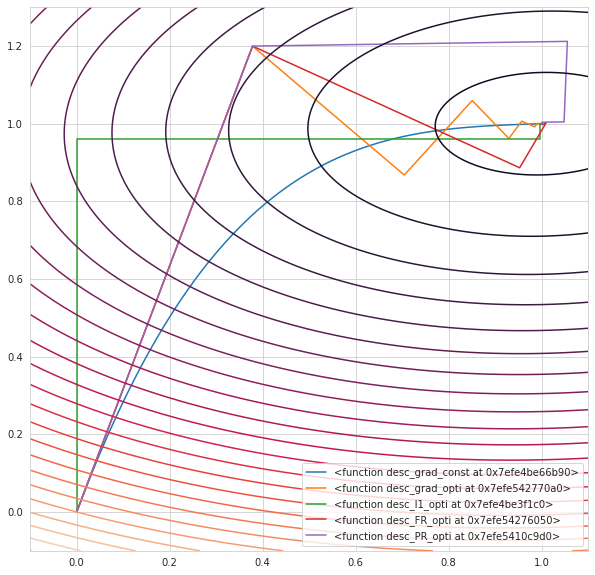

In [84]:
dim=2
A,b = create_system(dim,cond=3.)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(10,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti,desc_PR_opti)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)

    res = np.array(res)
    plt.plot(res[:,0], res[:,1],label=method)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -0.1, 1.1, -0.1, 1.3

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z,25) 

plt.show

En dimension n plus grande (par exemple n=10), vous pourrez tracer le nombre d'itérations nécessaires pour converger en fonction du conditionnement (5,10,50,100,500,1000).

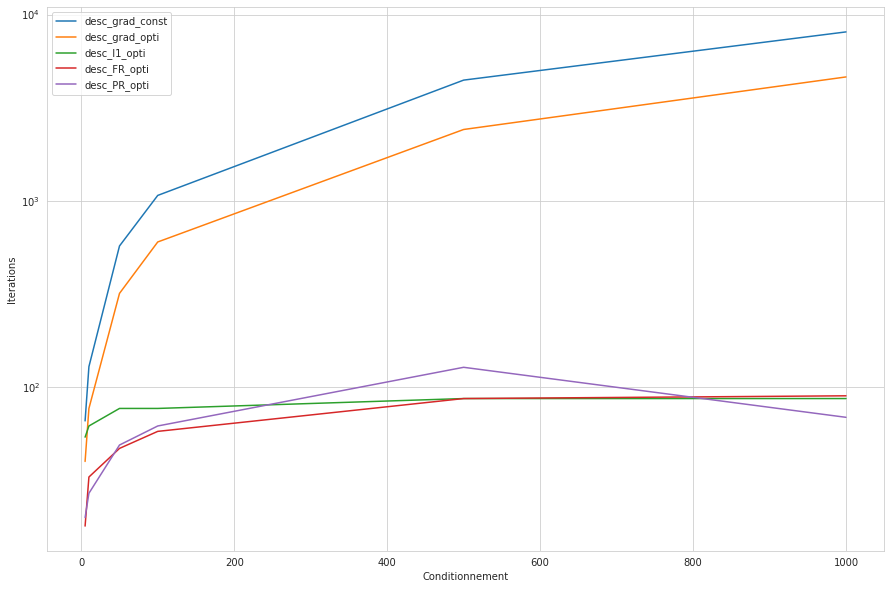

In [85]:
dim=10
conds = [5,10,50,100,500,1000]
systems = [create_system(dim,cond=val) for val in conds]
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti)

for method in Liste_method:
    iters = []
    for i in range(len(conds)):
        cond = conds[i]
        A,b = systems[i]
        b=A@x_exact
        
        if method == desc_grad_const:
            res = method(quadraticn_,x0,mu=0.9/cond)
        else:
            res = method(quadraticn_,x0)

        res = np.array(res)
        
        iters.append(len(res))
        
    plt.plot(conds, iters,label=method.__name__)

plt.legend()
plt.xlabel("Conditionnement")
plt.ylabel("Iterations")
plt.yscale("log")

plt.show()

Vous pouvez aussi regarder pour une certaine valeur de conditionnement, comment varie la distance à la solution exacte en fonction de l'itération.

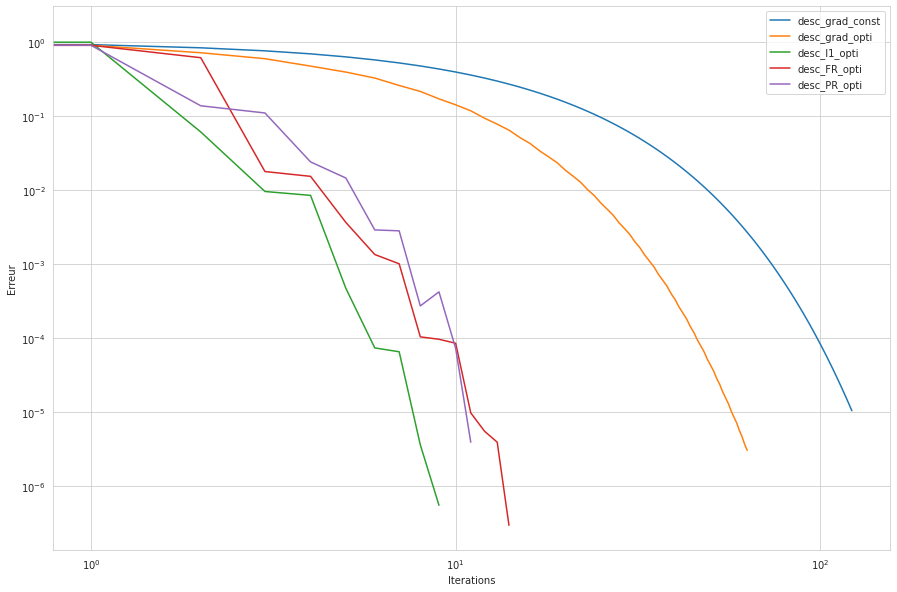

In [86]:
dim=2
cond = 10
x_exact=np.zeros(dim)+1.
A,b = create_system(dim, cond)
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti)
max_iter = -1
for method in Liste_method:
    iters = []
    errors = []
    
    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)

    res = np.array(res)
    errors = [np.linalg.norm(x - x_exact) for x in res]
    iters =  [i for i in range(len(res))]
    plt.plot(iters, errors,label=method.__name__)

plt.legend()
plt.xlabel("Iterations")
plt.xscale("log")
plt.ylabel("Erreur")
plt.yscale("log")
plt.show()

In [87]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["method", "dim", "nb_iter", "error", "time"])
it = 0
for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            t0 = time.time()
            res = gd(f, x0)
            gd_time = time.time() - t0
            res = np.array(res, dtype=object)
            error = np.linalg.norm(res[-1] - x_exact)
            df_GD.loc[f"{f_name}{it}"] = pd.Series({
                "method": f"{gd.__name__}",
                "dim": dim,
                "nb_iter": len(res),
                "error": error if error < 1E5 else math.inf,
                "time" : gd_time
            })
            it += 1
display(df_GD)

method dim nb_iter     error      time
quadraticn_0  desc_grad_const   2    6960  0.001002  0.705417
quadraticn_1   desc_grad_opti   2      20  0.000001  0.002571
quadraticn_2     desc_l1_opti   2       8  0.000001  0.001135
quadraticn_3     desc_FR_opti   2      11       0.0  0.001759
quadraticn_4     desc_PR_opti   2       9  0.000001  0.002921
quadraticn_5  desc_grad_const  10    7218  0.001063   2.51442
quadraticn_6   desc_grad_opti  10      25  0.000001   0.01779
quadraticn_7     desc_l1_opti  10      65  0.000002  0.042365
quadraticn_8     desc_FR_opti  10      16  0.000001   0.01428
quadraticn_9     desc_PR_opti  10      15  0.000002   0.01365
Rosenbrock10  desc_grad_const   2   10000  0.012517  0.390152
Rosenbrock11   desc_grad_opti   2    7035  0.000977  2.838852
Rosenbrock12     desc_l1_opti   2    4245  0.000764  2.153019
Rosenbrock13     desc_FR_opti   2      32  0.000166  0.020277
Rosenbrock14     desc_PR_opti   2      18  0.000062  0.016194

### 4. comportement si la fonction à optimiser n'est pas convexe sur $\mathbb{R}^2$ et n'admet pas un minimum global

Nous vous proposons de regarder le comportement de ces différents algorithmes de descente dans le cas de quelques fonctions introduites au début du TP, telles que multitrous2, cubic2.

<function matplotlib.pyplot.show(close=None, block=None)>

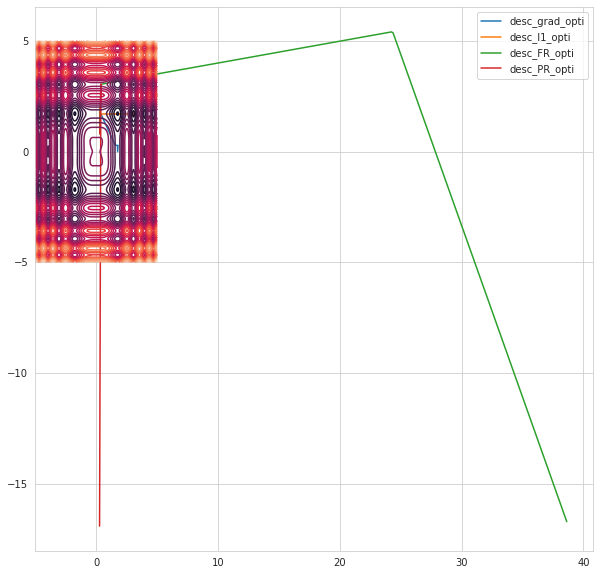

In [88]:
dim=2
x_exact=np.zeros(dim)+1.

np.random.seed(69)

x0= np.random.random_sample(dim, )

plt.figure(figsize=(10,10))

Liste_method=(desc_grad_opti,desc_l1_opti,desc_FR_opti,desc_PR_opti)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(multitrous2_,x0,mu=0.9/cond)
    else:
        res = method(multitrous2_,x0)

    res = np.array(res)
    plt.plot(res[:,0], res[:,1],label=method.__name__)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -5, 5, -5, 5

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=multitrous2_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z, 25) 

plt.show

[0.31564591 0.45303068]


<function matplotlib.pyplot.show(close=None, block=None)>

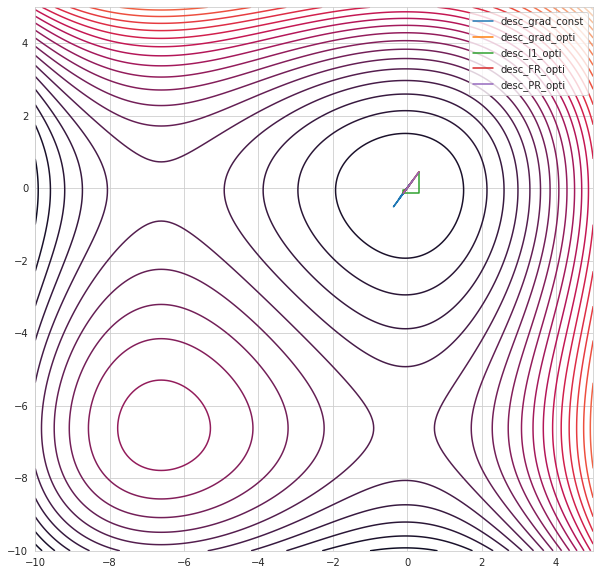

In [89]:
dim=2
x_exact=np.zeros(dim)+1.

np.random.seed(420)

x0= np.random.random_sample(dim, )

print(x0)
plt.figure(figsize=(10,10))

Liste_method=(desc_grad_const, desc_grad_opti,desc_l1_opti, desc_FR_opti, desc_PR_opti)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(cubic2_,x0,mu=0.9/cond)
    else:
        res = method(cubic2_,x0)

    res = np.array(res)
    plt.plot(res[:,0], res[:,1],label=method.__name__)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -10, 5, -10, 5

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=cubic2_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z, 25) 

plt.show

Que constatez-vous ?

On peut constater que pour les fonctions `multitrous2_` et `cubic2_`, les algorithmes de descentes de gradient ne convergent pas pour n'importe quels points.

## V Accélérations

Il y a des stratégies standards d'accélération de descente de gradients ; on en invente même tous les ans. Il n'y a pas nécessairement de relation d'ordre entre celles-ci, certaines sont plus adaptées que d'autres à des problèmes spécifiques et inversement. On vous propose d'en implémenter $1$ parmi les 3 qui vous sont proposées ici, il s'agit en particulier d'un travail bibliographique (simple).

1. Implémenter la *Momentum Optimisation*. Cherchez à en comprendre le sens.

In [91]:
def momentum(f, p0, gamma=0.95, mu=0.001, eps=1E-6):
    max_iter = 10000
    iter = 1
    v = 0
    points = [p0]
    d = -gradient(f, p0)
    pk = p0
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and iter < max_iter:
        pk = pk_1
        points.append(pk)
        d = -gradient(f, pk)
        v = (gamma * v) + mu * d 
        pk_1 = pk + v
        iter += 1
    return points

In [95]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [momentum]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim", "gamma", "mu", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for gamma in np.arange(0.1, 1.0, 0.1):
                for mu in [1, 0.8, 0.5, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001]:
                    t0 = time.time()
                    res = gd(f, x0, gamma, mu)
                    gd_time = time.time() - t0
                    res = np.array(res, dtype=object)
                    error = np.linalg.norm(res[-1] - x_exact)
                    df_GD.loc[f"{f_name}_{dim}_{round(gamma, 2)}_{mu}"] = pd.Series({
                        "dim": dim,
                        "gamma": gamma,
                        "mu": mu,
                        "nb_iter": len(res),
                        "error": error if error < 1E5 else math.inf,
                        "time" : gd_time
                    })
display(df_GD)

dim  gamma     mu  nb_iter         error      time
quadraticn__2_0.1_1        2.0    0.1  1.000     62.0           inf  0.012642
quadraticn__2_0.1_0.8      2.0    0.1  0.800    132.0           inf  0.033314
quadraticn__2_0.1_0.5      2.0    0.1  0.500     15.0  4.070008e-07  0.003747
quadraticn__2_0.1_0.1      2.0    0.1  0.100    100.0  8.031285e-06  0.008818
quadraticn__2_0.1_0.05     2.0    0.1  0.050    193.0  1.728794e-05  0.019064
quadraticn__2_0.1_0.02     2.0    0.1  0.020    449.0  4.441556e-05  0.090048
quadraticn__2_0.1_0.01     2.0    0.1  0.010    840.0  8.967742e-05  0.080817
quadraticn__2_0.1_0.005    2.0    0.1  0.005   1559.0  1.801776e-04  0.163409
quadraticn__2_0.1_0.001    2.0    0.1  0.001   6358.0  9.024750e-04  0.794812
quadraticn__2_0.2_1        2.0    0.2  1.000     64.0           inf  0.032902
quadraticn__2_0.2_0.8      2.0    0.2  0.800  10000.0           inf  1.783556
quadraticn__2_0.2_0.5      2.0    0.2  0.500     19.0  2.330866e-07  0.002259
quadraticn__2_0.2_0.1      2.0    0.2  0.100     87.0  7.460635e-06  0.009527
quadraticn__2_0.2_0.05     2.0    0.2  0.050    171.0  1.567560e-05  0.020207
quadraticn__2_0.2_0.02     2.0    0.2  0.020    402.0  3.947006e-05  0.048451
quadraticn__2_0.2_0.01     2.0    0.2  0.010    755.0  7.916073e-05  0.094272
quadraticn__2_0.2_0.005    2.0    0.2  0.005   1404.0  1.593215e-04  0.134401
quadraticn__2_0.2_0.001    2.0    0.2  0.001   5745.0  8.020856e-04  0.562356
quadraticn__2_0.3_1        2.0    0.3  1.000    141.0           inf  0.017467
quadraticn__2_0.3_0.8      2.0    0.3  0.800     38.0  5.971596e-07  0.003068
quadraticn__2_0.3_0.5      2.0    0.3  0.500     24.0  8.229969e-07  0.002268
quadraticn__2_0.3_0.1      2.0    0.3  0.100     74.0  5.850859e-06  0.005744
quadraticn__2_0.3_0.05     2.0    0.3  0.050    149.0  1.320148e-05  0.026327
quadraticn__2_0.3_0.02     2.0    0.3  0.020    354.0  3.443628e-05  0.081440
quadraticn__2_0.3_0.01     2.0    0.3  0.010    668.0  6.897231e-05  0.109368
quadraticn__2_0.3_0.005    2.0    0.3  0.005   1245.0  1.395784e-04  0.098110
quadraticn__2_0.3_0.001    2.0    0.3  0.001   5120.0  7.008285e-04  0.667954
quadraticn__2_0.4_1        2.0    0.4  1.000    220.0           inf  0.027186
quadraticn__2_0.4_0.8      2.0    0.4  0.800     30.0  2.309539e-06  0.002614
quadraticn__2_0.4_0.5      2.0    0.4  0.500     31.0  8.153704e-07  0.002890
quadraticn__2_0.4_0.1      2.0    0.4  0.100     58.0  4.909665e-06  0.004774
quadraticn__2_0.4_0.05     2.0    0.4  0.050    126.0  1.038888e-05  0.020142
quadraticn__2_0.4_0.02     2.0    0.4  0.020    305.0  2.893901e-05  0.058407
quadraticn__2_0.4_0.01     2.0    0.4  0.010    579.0  5.871265e-05  0.070039
quadraticn__2_0.4_0.005    2.0    0.4  0.005   1083.0  1.193911e-04  0.138911
quadraticn__2_0.4_0.001    2.0    0.4  0.001   4479.0  6.007358e-04  0.499811
quadraticn__2_0.5_1        2.0    0.5  1.000  10000.0           inf  1.284405
quadraticn__2_0.5_0.8      2.0    0.5  0.800     44.0  5.964493e-07  0.005863
quadraticn__2_0.5_0.5      2.0    0.5  0.500     37.0  2.845548e-06  0.002917
quadraticn__2_0.5_0.1      2.0    0.5  0.100     40.0  2.005471e-06  0.003461
quadraticn__2_0.5_0.05     2.0    0.5  0.050    100.0  7.889952e-06  0.008832
quadraticn__2_0.5_0.02     2.0    0.5  0.020    254.0  2.328711e-05  0.045917
quadraticn__2_0.5_0.01     2.0    0.5  0.010    487.0  4.868417e-05  0.063344
quadraticn__2_0.5_0.005    2.0    0.5  0.005    917.0  9.889449e-05  0.167912
quadraticn__2_0.5_0.001    2.0    0.5  0.001   3821.0  5.000970e-04  0.681338
quadraticn__2_0.6_1        2.0    0.6  1.000     60.0  6.972992e-08  0.007257
quadraticn__2_0.6_0.8      2.0    0.6  0.800     44.0  2.335566e-05  0.022370
quadraticn__2_0.6_0.5      2.0    0.6  0.500     49.0  3.332232e-06  0.007532
quadraticn__2_0.6_0.1      2.0    0.6  0.100     50.0  3.346796e-06  0.006911
quadraticn__2_0.6_0.05     2.0    0.6  0.050     64.0  4.241794e-06  0.033311
quadraticn__2_0.6_0.02     2.0    0.6  0.020    1

2. Implémenter la *Nesterov Optimisation*. Cherchez à en comprendre le sens.

In [92]:
def nesterov(f, p0, gamma=0.95, mu=0.001, eps=1E-6):
    max_iter = 10000
    iter = 1
    v = 0
    points = [p0]
    d = -gradient(f, p0) 
    pk = p0
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and iter < max_iter:
        pk = pk_1
        points.append(pk)
        d = -gradient(f, pk + (gamma * v))
        v = (gamma * v) + mu * d 
        pk_1 = pk + v
        iter += 1
    return points

In [96]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [nesterov]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim", "gamma", "mu", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for gamma in np.arange(0.1, 1.0, 0.1):
                for mu in [1, 0.8, 0.5, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001]:
                    t0 = time.time()
                    res = gd(f, x0, gamma, mu)
                    gd_time = time.time() - t0
                    res = np.array(res, dtype=object)
                    error = np.linalg.norm(res[-1] - x_exact)
                    df_GD.loc[f"{f_name}_{dim}_{round(gamma, 2)}_{mu}"] = pd.Series({
                        "dim": dim,
                        "gamma": gamma,
                        "mu": mu,
                        "nb_iter": len(res),
                        "error": error if error < 1E5 else math.inf,
                        "time" : gd_time
                    })
display(df_GD)

dim  gamma     mu  nb_iter         error      time
quadraticn__2_0.1_1        2.0    0.1  1.000     41.0           inf  0.010242
quadraticn__2_0.1_0.8      2.0    0.1  0.800     97.0           inf  0.015893
quadraticn__2_0.1_0.5      2.0    0.1  0.500     32.0  4.787514e-07  0.002843
quadraticn__2_0.1_0.1      2.0    0.1  0.100    101.0  8.332818e-06  0.010363
quadraticn__2_0.1_0.05     2.0    0.1  0.050    194.0  1.744327e-05  0.047766
quadraticn__2_0.1_0.02     2.0    0.1  0.020    450.0  4.443944e-05  0.073282
quadraticn__2_0.1_0.01     2.0    0.1  0.010    841.0  8.962092e-05  0.137085
quadraticn__2_0.1_0.005    2.0    0.1  0.005   1560.0  1.800487e-04  0.332898
quadraticn__2_0.1_0.001    2.0    0.1  0.001   6359.0  9.021800e-04  0.978394
quadraticn__2_0.2_1        2.0    0.2  1.000     43.0           inf  0.004664
quadraticn__2_0.2_0.8      2.0    0.2  0.800     76.0           inf  0.006858
quadraticn__2_0.2_0.5      2.0    0.2  0.500     47.0  4.986427e-07  0.005301
quadraticn__2_0.2_0.1      2.0    0.2  0.100     90.0  7.231991e-06  0.012889
quadraticn__2_0.2_0.05     2.0    0.2  0.050    174.0  1.506915e-05  0.034140
quadraticn__2_0.2_0.02     2.0    0.2  0.020    404.0  3.956031e-05  0.062763
quadraticn__2_0.2_0.01     2.0    0.2  0.010    756.0  8.007967e-05  0.069306
quadraticn__2_0.2_0.005    2.0    0.2  0.005   1405.0  1.600874e-04  0.125293
quadraticn__2_0.2_0.001    2.0    0.2  0.001   5747.0  8.015205e-04  0.482627
quadraticn__2_0.3_1        2.0    0.3  1.000     62.0           inf  0.006914
quadraticn__2_0.3_0.8      2.0    0.3  0.800     56.0           inf  0.005516
quadraticn__2_0.3_0.5      2.0    0.3  0.500     77.0  4.920454e-07  0.007256
quadraticn__2_0.3_0.1      2.0    0.3  0.100     78.0  6.368717e-06  0.007488
quadraticn__2_0.3_0.05     2.0    0.3  0.050    153.0  1.293984e-05  0.014258
quadraticn__2_0.3_0.02     2.0    0.3  0.020    357.0  3.464288e-05  0.037972
quadraticn__2_0.3_0.01     2.0    0.3  0.010    670.0  6.990756e-05  0.039702
quadraticn__2_0.3_0.005    2.0    0.3  0.005   1247.0  1.402782e-04  0.082160
quadraticn__2_0.3_0.001    2.0    0.3  0.001   5122.0  7.010224e-04  0.459098
quadraticn__2_0.4_1        2.0    0.4  1.000     55.0           inf  0.002778
quadraticn__2_0.4_0.8      2.0    0.4  0.800     83.0           inf  0.008619
quadraticn__2_0.4_0.5      2.0    0.4  0.500    171.0  5.208285e-07  0.011076
quadraticn__2_0.4_0.1      2.0    0.4  0.100     65.0  5.113797e-06  0.006402
quadraticn__2_0.4_0.05     2.0    0.4  0.050    130.0  1.168772e-05  0.010436
quadraticn__2_0.4_0.02     2.0    0.4  0.020    309.0  2.934969e-05  0.025011
quadraticn__2_0.4_0.01     2.0    0.4  0.010    582.0  5.971799e-05  0.051332
quadraticn__2_0.4_0.005    2.0    0.4  0.005   1086.0  1.200633e-04  0.095020
quadraticn__2_0.4_0.001    2.0    0.4  0.001   4482.0  6.007250e-04  0.399362
quadraticn__2_0.5_1        2.0    0.5  1.000     63.0           inf  0.005716
quadraticn__2_0.5_0.8      2.0    0.5  0.800     77.0           inf  0.006201
quadraticn__2_0.5_0.5      2.0    0.5  0.500  10000.0           inf  0.834902
quadraticn__2_0.5_0.1      2.0    0.5  0.100     48.0  3.568898e-06  0.004414
quadraticn__2_0.5_0.05     2.0    0.5  0.050    107.0  8.398180e-06  0.011076
quadraticn__2_0.5_0.02     2.0    0.5  0.020    259.0  2.406256e-05  0.022094
quadraticn__2_0.5_0.01     2.0    0.5  0.010    492.0  4.885322e-05  0.046721
quadraticn__2_0.5_0.005    2.0    0.5  0.005    921.0  9.960529e-05  0.079015
quadraticn__2_0.5_0.001    2.0    0.5  0.001   3824.0  5.009282e-04  0.397193
quadraticn__2_0.6_1        2.0    0.6  1.000     89.0           inf  0.007156
quadraticn__2_0.6_0.8      2.0    0.6  0.800     87.0           inf  0.007014
quadraticn__2_0.6_0.5      2.0    0.6  0.500  10000.0           inf  1.389435
quadraticn__2_0.6_0.1      2.0    0.6  0.100     44.0  1.123027e-06  0.006625
quadraticn__2_0.6_0.05     2.0    0.6  0.050     77.0  6.543311e-06  0.009346
quadraticn__2_0.6_0.02     2.0    0.6  0.020    2

3. Implémenter la *Adam Optimisation*. Cherchez à en comprendre le sens.

In [93]:
def adam(f, p0, mu=0.01, eps=1E-6, beta1=0.9, beta2=0.999):
    max_iter = 10000
    m = 0
    v = 0
    i = 1
    points = [p0]
    d = -gradient(f, p0)
    pk = p0
    pk_1 = pk + mu * d
    while np.linalg.norm(pk_1 - pk) >= eps and i < max_iter:
        pk = pk_1
        points.append(pk)
        d = -gradient(f, pk)
        m = beta1 * m + (1. - beta1) * d
        v = beta2 * v + (1. - beta2) * d**2
        m_hat = m / (1. - beta1**(i + 1))
        v_hat = v / (1. - beta2**(i + 1))
        pk_1 = pk + (mu / (np.sqrt((v_hat)) + eps)) * m_hat
        i += 1
    return points

In [100]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [adam]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim", "mu", "beta1", "beta2", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for mu in [1, 0.8, 0.5, 0.1, 0.05, 0.01, 0.001]:
                for beta1 in [0.5, 0.8, 0.95, 0.99]:
                    for beta2 in [0.5,  0.8, 0.95, 0.99]:
                        t0 = time.time()
                        res = gd(f, x0, mu, beta1, beta2)
                        gd_time = time.time() - t0
                        res = np.array(res, dtype=object)
                        error = np.linalg.norm(res[-1] - x_exact)
                        df_GD.loc[f"{f_name}_{dim}_{mu}_{beta1}_{beta2}"] = pd.Series({
                            "dim": dim,
                            "mu": mu,
                            "beta1": beta1,
                            "beta2": beta2,
                            "nb_iter": len(res),
                            "error": error if error < 1E5 else math.inf,
                            "time" : gd_time
                        })
display(df_GD)

dim     mu  beta1  beta2  nb_iter     error  \
quadraticn__2_1_0.5_0.5          2.0  1.000   0.50   0.50      5.0  0.271077   
quadraticn__2_1_0.5_0.8          2.0  1.000   0.50   0.80      5.0  0.286888   
quadraticn__2_1_0.5_0.95         2.0  1.000   0.50   0.95      6.0  0.729399   
quadraticn__2_1_0.5_0.99         2.0  1.000   0.50   0.99      6.0  0.730486   
quadraticn__2_1_0.8_0.5          2.0  1.000   0.80   0.50      3.0  1.143034   
quadraticn__2_1_0.8_0.8          2.0  1.000   0.80   0.80      2.0  1.930646   
quadraticn__2_1_0.8_0.95         2.0  1.000   0.80   0.95      2.0  1.930646   
quadraticn__2_1_0.8_0.99         2.0  1.000   0.80   0.99      2.0  1.930646   
quadraticn__2_1_0.95_0.5         2.0  1.000   0.95   0.50      2.0  1.930646   
quadraticn__2_1_0.95_0.8         2.0  1.000   0.95   0.80      2.0  1.930646   
quadraticn__2_1_0.95_0.95        2.0  1.000   0.95   0.95      2.0  1.930646   
quadraticn__2_1_0.95_0.99        2.0  1.000   0.95   0.99      2.0  1.930646   
quadraticn__2_1_0.99_0.5         2.0  1.000   0.99   0.50      2.0  1.930646   
quadraticn__2_1_0.99_0.8         2.0  1.000   0.99   0.80      2.0  1.930646   
quadraticn__2_1_0.99_0.95        2.0  1.000   0.99   0.95      2.0  1.930646   
quadraticn__2_1_0.99_0.99        2.0  1.000   0.99   0.99      2.0  1.930646   
quadraticn__2_0.8_0.5_0.5        2.0  0.800   0.50   0.50      4.0  0.179336   
quadraticn__2_0.8_0.5_0.8        2.0  0.800   0.50   0.80      4.0  0.268523   
quadraticn__2_0.8_0.5_0.95       2.0  0.800   0.50   0.95      5.0  0.313219   
quadraticn__2_0.8_0.5_0.99       2.0  0.800   0.50   0.99      5.0  0.304653   
quadraticn__2_0.8_0.8_0.5        2.0  0.800   0.80   0.50      2.0  1.368497   
quadraticn__2_0.8_0.8_0.8        2.0  0.800   0.80   0.80      2.0  1.368497   
quadraticn__2_0.8_0.8_0.95       2.0  0.800   0.80   0.95      2.0  1.368497   
quadraticn__2_0.8_0.8_0.99       2.0  0.800   0.80   0.99      2.0  1.368497   
quadraticn__2_0.8_0.95_0.5       2.0  0.800   0.95   0.50      2.0  1.368497   
quadraticn__2_0.8_0.95_0.8       2.0  0.800   0.95   0.80      2.0  1.368497   
quadraticn__2_0.8_0.95_0.95      2.0  0.800   0.95   0.95      2.0  1.368497   
quadraticn__2_0.8_0.95_0.99      2.0  0.800   0.95   0.99      2.0  1.368497   
quadraticn__2_0.8_0.99_0.5       2.0  0.800   0.99   0.50      2.0  1.368497   
quadraticn__2_0.8_0.99_0.8       2.0  0.800   0.99   0.80      2.0  1.368497   
quadraticn__2_0.8_0.99_0.95      2.0  0.800   0.99   0.95      2.0  1.368497   
quadraticn__2_0.8_0.99_0.99      2.0  0.800   0.99   0.99      2.0  1.368497   
quadraticn__2_0.5_0.5_0.5        2.0  0.500   0.50   0.50      2.0  0.711110   
quadraticn__2_0.5_0.5_0.8        2.0  0.500   0.50   0.80      2.0  0.711110   
quadraticn__2_0.5_0.5_0.95       2.0  0.500   0.50   0.95      2.0  0.711110   
quadraticn__2_0.5_0.5_0.99       2.0  0.500   0.50   0.99      2.0  0.711110   
quadraticn__2_0.5_0.8_0.5        2.0  0.500   0.80   0.50      2.0  0.711110   
quadraticn__2_0.5_0.8_0.8        2.0  0.500   0.80   0.80      2.0  0.711110   
quadraticn__2_0.5_0.8_0.95       2.0  0.500   0.80   0.95      2.0  0.711110   
quadraticn__2_0.5_0.8_0.99       2.0  0.500   0.80   0.99      2.0  0.711110   
quadraticn__2_0.5_0.95_0.5       2.0  0.500   0.95   0.50      2.0  0.711110   
quadraticn__2_0.5_0.95_0.8       2.0  0.500   0.95   0.80      2.0  0.711110   
quadraticn__2_0.5_0.95_0.95      2.0  0.500   0.95   0.95      2.0  0.711110   
quadraticn__2_0.5_0.95_0.99      2.0  0.500   0.95   0.99      2.0  0.711110   
quadraticn__2_0.5_0.99_0.5       2.0  0.500   0.99   0.50      2.0  0.711110   
quadraticn__2_0.5_0.99_0.8       2.0  0.500   0.99   0.80      2.0  0.711110   
quadraticn__2_0.5_0.99_0.95      2.0  0.500   0.99   0.95      2.0  0.711110   
quadraticn__2_0.5_0.99_0.99      2.0  0.500   0.99   0.99      2.0  0.711110   
quadraticn__2_0.1_0.5_0.5        2.0  0.100   0.50   0.50      1.0  1.414214   
quadraticn__2_0.1_0.5_0.8        

4. Comparer l'accélération choisie avec les méthodes précédentes précédentes.

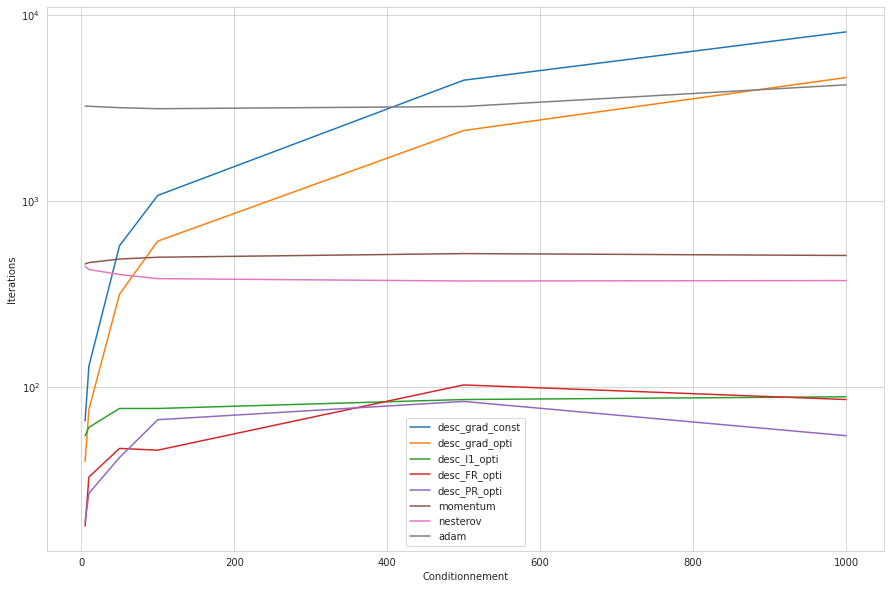

In [147]:
dim=10
conds = [5,10,50,100,500,1000]
systems = [create_system(dim,cond=val) for val in conds]
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam)

for method in Liste_method:
    iters = []
    for i in range(len(conds)):
        cond = conds[i]
        A,b = systems[i]
        b=A@x_exact
        
        if method == desc_grad_const:
            res = method(quadraticn_,x0,mu=0.9/cond)
        else:
            res = method(quadraticn_,x0)

        res = np.array(res)
        
        iters.append(len(res))
        
    plt.plot(conds, iters,label=method.__name__)

plt.legend()
plt.xlabel("Conditionnement")
plt.ylabel("Iterations")
plt.yscale("log")

plt.show()

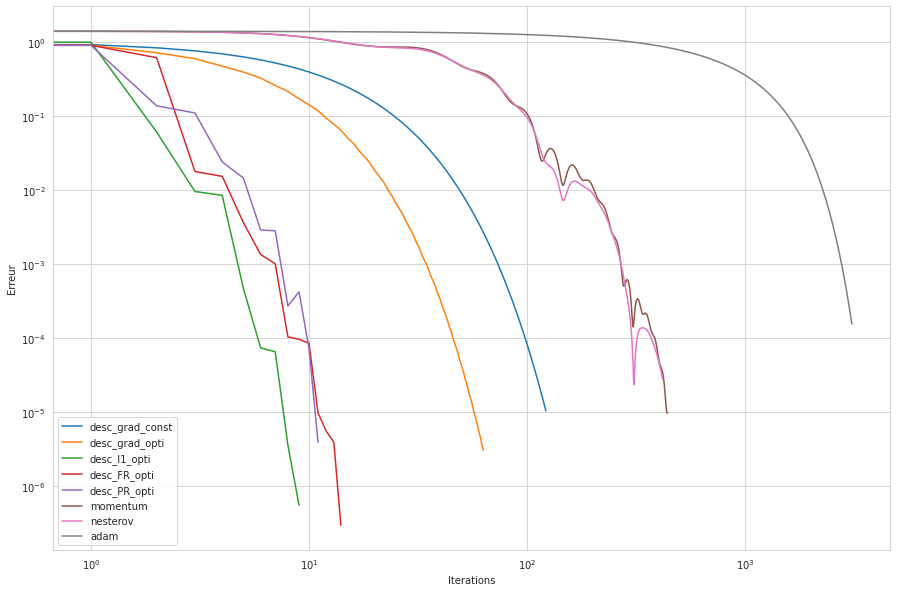

In [146]:
dim=2
cond = 10
x_exact=np.zeros(dim)+1.
A,b = create_system(dim, cond)
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam)
max_iter = -1
for method in Liste_method:
    iters = []
    errors = []
    
    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)

    res = np.array(res)
    errors = [np.linalg.norm(x - x_exact) for x in res]
    iters =  [i for i in range(len(res))]
    plt.plot(iters, errors,label=method.__name__)

plt.legend()
plt.xlabel("Iterations")
plt.xscale("log")
plt.ylabel("Erreur")
plt.yscale("log")
plt.show()

In [99]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["method", "dim", "nb_iter", "error", "time"])
it = 0
for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            t0 = time.time()
            res = gd(f, x0)
            gd_time = time.time() - t0
            res = np.array(res, dtype=object)
            error = np.linalg.norm(res[-1] - x_exact)
            df_GD.loc[f"{f_name}{it}"] = pd.Series({
                "method": f"{gd.__name__}",
                "dim": dim,
                "nb_iter": len(res),
                "error": error if error < 1E5 else math.inf,
                "time" : gd_time
            })
            it += 1
display(df_GD)

method dim nb_iter     error      time
quadraticn_0   desc_grad_const   2    6960  0.001002  0.733901
quadraticn_1    desc_grad_opti   2      20  0.000001  0.006266
quadraticn_2      desc_l1_opti   2       8  0.000001  0.002353
quadraticn_3      desc_FR_opti   2      11       0.0  0.005248
quadraticn_4      desc_PR_opti   2       9  0.000001   0.00275
quadraticn_5          momentum   2     433  0.000015  0.032891
quadraticn_6          nesterov   2     428  0.000021  0.039804
quadraticn_7              adam   2     336  0.000004  0.044637
quadraticn_8   desc_grad_const  10    7218  0.001063  2.531912
quadraticn_9    desc_grad_opti  10      25  0.000001  0.035919
quadraticn_10     desc_l1_opti  10      65  0.000002  0.055445
quadraticn_11     desc_FR_opti  10      16  0.000001  0.017211
quadraticn_12     desc_PR_opti  10      15  0.000002  0.017454
quadraticn_13         momentum  10     447  0.000034  0.124421
quadraticn_14         nesterov  10     442  0.000024  0.114677
quadraticn_15             adam  10     346  0.000016  0.105336
Rosenbrock16   desc_grad_const   2   10000  0.012517  0.628505
Rosenbrock17    desc_grad_opti   2    7035  0.000977  5.632144
Rosenbrock18      desc_l1_opti   2    4245  0.000764  3.572733
Rosenbrock19      desc_FR_opti   2      32  0.000166  0.013839
Rosenbrock20      desc_PR_opti   2      18  0.000062  0.024333
Rosenbrock21          momentum   2     838  0.000101  0.078138
Rosenbrock22          nesterov   2     857  0.000102  0.064739
Rosenbrock23              adam   2     624  0.000035  0.063071

## VI - "Les" méthodes de Newton

### 1. la méthode de Newton

Dans les méthodes de descente précédentes, on cherchait à chaque étape à minimiser le Développement Limité d'ordre 1 de J au voisinage de ${\bf p_k}$: $h \mapsto J({\bf p_k}) + \nabla J({\bf p_k}) ^T h$.

Dans la méthode de Newton, on cherche à minimiser le Développement Limité d'ordre 2 de J au voisinage de ${\bf p}_k$ : $h \mapsto J({\bf p}_k) + \nabla J({\bf p}_k) ^T h + \dfrac{1}{2}h^T H_J({\bf p}_k) h$ où $H_J({\bf p}_k)$ est la Hessienne de J au point ${\bf p}_k$.

A quelle direction de descente, cette minimisation nous amène-t-elle?

Réponse:


On passe de la direction ${\bf d}_k$ à la direction ${\bf d}_{k+1}$ par la relation de récurrence:
$${\bf d}_{k+1}=-H_J({\bf p}_k)^{-1} \, \nabla J({\bf p}_k) .$$

#### a. Implémenter la méthode de Newton.

En apparence, implémenter la méthode de Newton (qui converge très rapidement) ne semble pas différent que les méthodes de descente vues précédemment (Une fois qu'on a obtenu ${\bf d}_k$ comme direction de descente, on peut calculer $\mu_k$ et donc itérer "tranquillement).

En réalité cette méthode n'est pas facile à implémenter et surtout coûteuse car il faut calculer à chaque itération la Hessienne de $J$ au point ${\bf p}_k)$ et ensuite l'inverser.

Vous pouvez essayer de l'implémenter dans le cas particulier de la fonction quadraticn_ car alors la matrice Hessienne est constante et ne dépend donc pas du point ${\bf p}_k)$, ce qui vous permet de calculer une fois pour toute son inverse (par le module linalg de numpy par exemple).

Par contre implémenter cette méthode dans le cas d'une fonction dont on ne connaît pas explicitement la Hessienne, et surtout l'inverse de cette dernière est à déconseiller.

In [101]:
x0 = np.array([2.0, 3.0])

def hessian(f, x, dx=1E-6):
    N = x.shape[0]
    hess_ = np.zeros((N, N))
    grad = gradient(f, x)
    for i in range(N):
        tmp = x[i]
        x[i] += dx
        grad_1 =  gradient(f, x)
        hess_[:,i] = ((grad_1 - grad)/dx)
        x[i] = tmp
    return hess_

hessian((lambda x: x[0]**2 + x[1]), x0)

array([[2.04281037, 0.        ],
       [0.        , 0.        ]])

In [102]:
def newton(f, p0, gamma=0.95, mu=0.001, eps=1E-6):
    max_iter = 10000
    i = 1
    points = [p0]
    d = -gradient(f, p0)
    pk = p0
    pk_1 = pk + mu * d
    hess = np.linalg.inv(hessian(f, pk))
    while np.linalg.norm(pk_1 - pk) >= eps and i < max_iter:
        pk = pk_1
        points.append(pk)
        d = - hess @ gradient(f, pk)
        pk += d
        i += 1
    return points

In [120]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [newton]
test_methods = [(quadraticn_, [2, 10])]

df_GD = pd.DataFrame(columns=["dim", "gamma", "mu", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for mu in [1, 0.8, 0.5, 0.1, 0.05, 0.01, 0.001]:
                for gamma in np.arange(0.1, 0.9, 0.1):
                        t0 = time.time()
                        res = gd(f, x0, gamma, mu)
                        gd_time = time.time() - t0
                        res = np.array(res, dtype=object)
                        error = np.linalg.norm(res[-1] - x_exact)
                        df_GD.loc[f"{f_name}_{dim}_{round(gamma, 2)}_{mu}"] = pd.Series({
                            "dim": dim,
                            "gamma": gamma,
                            "mu": mu,
                            "nb_iter": len(res),
                            "error": error if error < 1E5 else math.inf,
                            "time" : gd_time
                        })
display(df_GD)

dim  gamma     mu  nb_iter         error      time
quadraticn__2_0.1_1        2.0    0.1  1.000      2.0  6.860931e-08  0.009167
quadraticn__2_0.2_1        2.0    0.2  1.000      2.0  6.860931e-08  0.000551
quadraticn__2_0.3_1        2.0    0.3  1.000      2.0  6.860931e-08  0.005769
quadraticn__2_0.4_1        2.0    0.4  1.000      2.0  6.860931e-08  0.012260
quadraticn__2_0.5_1        2.0    0.5  1.000      2.0  6.860931e-08  0.008500
quadraticn__2_0.6_1        2.0    0.6  1.000      2.0  6.860931e-08  0.008616
quadraticn__2_0.7_1        2.0    0.7  1.000      2.0  6.860931e-08  0.006943
quadraticn__2_0.8_1        2.0    0.8  1.000      2.0  6.860931e-08  0.016453
quadraticn__2_0.1_0.8      2.0    0.1  0.800      2.0  7.640790e-08  0.015876
quadraticn__2_0.2_0.8      2.0    0.2  0.800      2.0  7.640790e-08  0.016701
quadraticn__2_0.3_0.8      2.0    0.3  0.800      2.0  7.640790e-08  0.010345
quadraticn__2_0.4_0.8      2.0    0.4  0.800      2.0  7.640790e-08  0.013418
quadraticn__2_0.5_0.8      2.0    0.5  0.800      2.0  7.640790e-08  0.009754
quadraticn__2_0.6_0.8      2.0    0.6  0.800      2.0  7.640790e-08  0.011806
quadraticn__2_0.7_0.8      2.0    0.7  0.800      2.0  7.640790e-08  0.007490
quadraticn__2_0.8_0.8      2.0    0.8  0.800      2.0  7.640790e-08  0.000517
quadraticn__2_0.1_0.5      2.0    0.1  0.500      2.0  2.965655e-08  0.000490
quadraticn__2_0.2_0.5      2.0    0.2  0.500      2.0  2.965655e-08  0.007781
quadraticn__2_0.3_0.5      2.0    0.3  0.500      2.0  2.965655e-08  0.001767
quadraticn__2_0.4_0.5      2.0    0.4  0.500      2.0  2.965655e-08  0.012773
quadraticn__2_0.5_0.5      2.0    0.5  0.500      2.0  2.965655e-08  0.006111
quadraticn__2_0.6_0.5      2.0    0.6  0.500      2.0  2.965655e-08  0.000510
quadraticn__2_0.7_0.5      2.0    0.7  0.500      2.0  2.965655e-08  0.007618
quadraticn__2_0.8_0.5      2.0    0.8  0.500      2.0  2.965655e-08  0.000500
quadraticn__2_0.1_0.1      2.0    0.1  0.100      2.0  9.362875e-09  0.006242
quadraticn__2_0.2_0.1      2.0    0.2  0.100      2.0  9.362875e-09  0.001603
quadraticn__2_0.3_0.1      2.0    0.3  0.100      2.0  9.362875e-09  0.000448
quadraticn__2_0.4_0.1      2.0    0.4  0.100      2.0  9.362875e-09  0.004001
quadraticn__2_0.5_0.1      2.0    0.5  0.100      2.0  9.362875e-09  0.000596
quadraticn__2_0.6_0.1      2.0    0.6  0.100      2.0  9.362875e-09  0.001033
quadraticn__2_0.7_0.1      2.0    0.7  0.100      2.0  9.362875e-09  0.000902
quadraticn__2_0.8_0.1      2.0    0.8  0.100      2.0  9.362875e-09  0.000559
quadraticn__2_0.1_0.05     2.0    0.1  0.050      2.0  1.265505e-08  0.000697
quadraticn__2_0.2_0.05     2.0    0.2  0.050      2.0  1.265505e-08  0.002126
quadraticn__2_0.3_0.05     2.0    0.3  0.050      2.0  1.265505e-08  0.000470
quadraticn__2_0.4_0.05     2.0    0.4  0.050      2.0  1.265505e-08  0.000491
quadraticn__2_0.5_0.05     2.0    0.5  0.050      2.0  1.265505e-08  0.001482
quadraticn__2_0.6_0.05     2.0    0.6  0.050      2.0  1.265505e-08  0.000496
quadraticn__2_0.7_0.05     2.0    0.7  0.050      2.0  1.265505e-08  0.000519
quadraticn__2_0.8_0.05     2.0    0.8  0.050      2.0  1.265505e-08  0.006882
quadraticn__2_0.1_0.01     2.0    0.1  0.010      2.0  1.580210e-08  0.001623
quadraticn__2_0.2_0.01     2.0    0.2  0.010      2.0  1.580210e-08  0.000535
quadraticn__2_0.3_0.01     2.0    0.3  0.010      2.0  1.580210e-08  0.000562
quadraticn__2_0.4_0.01     2.0    0.4  0.010      2.0  1.580210e-08  0.000492
quadraticn__2_0.5_0.01     2.0    0.5  0.010      2.0  1.580210e-08  0.009462
quadraticn__2_0.6_0.01     2.0    0.6  0.010      2.0  1.580210e-08  0.000537
quadraticn__2_0.7_0.01     2.0    0.7  0.010      2.0  1.580210e-08  0.012403
quadraticn__2_0.8_0.01     2.0    0.8  0.010      2.0  1.580210e-08  0.000774
quadraticn__2_0.1_0.001    2.0    0.1  0.001      2.0  1.684897e-08  0.000502
quadraticn__2_0.2_0.001    2.0    0.2  0.001      2.0  1.684897e-08  0.006600
quadraticn__2_0.3_0.001    2.0    0.3  0.001     

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [150]:
dim=10
cond=100
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = newton(quadraticn_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 2
x_calculé [1.00000114 0.99999998 1.         1.00000004 0.99999998 1.00000001
 0.99999997 0.99999999 1.00000001 0.99999984]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 2. la méthode de quasi-Newton

Pour éviter les inconvénients de la méthode de Newton, en particulier lorsque la Hessienne n'est plus constante, une idée est d'introduire une suite de matrices $H_k$ qui sont une approximation de $\bf {l'inverse}$ de la Hessienne au point ${\bf p}_k$.

Cette méthode qui s'appelle méthode BFGS (des initiales des auteurs) qui l'ont introduite, a l'avantage (énorme) de ne pas nécessiter le calcul de la Hessienne ou de son inverse. on retrouve donc en terme d'implémentation la simplicité des méthodes de descente, tout en ayant les propriétés de convergence de la méthode de Newton.

L'algorithme le décrivant est le suivant (très analogue aux algorithmes de descente:

La méthode est donc très analogue à la précédente

* prendre un point de départ quelconque ${\bf p}_0$, par exemple ${\bf p}_0 = ${\bf 0}
* prendre une matrice $H_0$ quelconque, par exemple $H_0= I_n$ 

Quand on est au point ${\bf p}_k$

* Choisir une direction de descente ${\bf d}_k = -H_k \, \nabla J({\bf p}_k)$

* Trouver $\mu_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

* Calculer $H_{k+1}$ en fonction de $H_{k+1}$, $J({\bf p}_k)$, $J({\bf p}_{k+1})$, $\nabla J({\bf p}_k)$ et $\nabla J({\bf p}_{k+1})$.

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.


Faire un petit peu de biblio pour trouver comment se calcule la suite des matrices $H_{k+1}$. La formule qui semble à première vue horrible, se programme en Python en 1 ligne en ne faisant que des multiplications de matrices et de vecteurs.

Réponse:
    $$H_{k+1} = (I - ρ_k * s_k * y_k^T)H_k(I - ρ_k * y_k * s_k^T) + ρ * s_k * s_k^T$$
    avec 
        $$ρ_k = \frac {1}{y_k^T s_k}$$  
        $$s_k = p_{k+1} - p_k$$  
        $$y_k = \nabla J(p_{k+1}) - \nabla J(p_k)$$

#### a. Implémenter la méthode de Quasi-Newton BFGS.

In [106]:
def desc_BFGS_opti (f, p0, alpha=0.4, beta=0.8, eps=1E-6):
    N = len(p0)
    grad = gradient(f,p0)
    H = np.eye(N) 
    pk = p0
    d = -H @ grad
    nu_k = backtrack(pk, f, d, alpha, beta)
    pk_1 = pk + nu_k * d

    points = [p0]
    i = 1
    max_iter = 10000
    while np.linalg.norm(pk_1 - pk) >= eps and i < max_iter:
        grad_new = gradient(f,pk_1)
        s = pk_1 - pk
        
        y = grad_new - grad
        
        y = np.array([y])
        s = np.array([s])
        
        y = np.reshape(y,(N,1))
        s = np.reshape(s,(N,1))
        rho = 1.0/(y.T.dot(s))
        
        left = np.eye(N)- rho * (s.dot(y.T))
        right = np.eye(N)- rho * (y.dot(s.T))
        
        H = (left @ H @ right) + ( rho * (s @ (s.T)))
        grad = grad_new
        d = -H @ grad
        nu_k = backtrack(pk, f, d)
        points.append(pk_1)
        pk = pk_1
        pk_1 = pk + nu_k * d
        i += 1
        
    return points

In [107]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_BFGS_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["dim", "alpha", "beta", "nb_iter", "error", "time"])

for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            for alpha in np.arange(0.1, 0.5, 0.1):
                for beta in np.arange(0.1, 1.0, 0.1):
                    t0 = time.time()
                    res = gd(f, x0, alpha, beta)
                    gd_time = time.time() - t0
                    res = np.array(res, dtype=object)
                    error = np.linalg.norm(res[-1] - x_exact)
                    df_GD.loc[f"{f_name}_{dim}_{round(alpha, 2)}_{round(beta, 2)}"] = pd.Series({
                        "dim": dim,
                        "alpha": alpha,
                        "beta": beta,
                        "nb_iter": len(res),
                        "error": error if error < 1E5 else math.inf,
                        "time" : gd_time
                    })
display(df_GD)

dim  alpha  beta  nb_iter     error      time
quadraticn__2_0.1_0.1    2.0    0.1   0.1      3.0  0.052873  0.011491
quadraticn__2_0.1_0.2    2.0    0.1   0.2      3.0  0.052873  0.011814
quadraticn__2_0.1_0.3    2.0    0.1   0.3      3.0  0.052873  0.494527
quadraticn__2_0.1_0.4    2.0    0.1   0.4      4.0  0.000058  0.004703
quadraticn__2_0.1_0.5    2.0    0.1   0.5      2.0  0.711110  0.335651
quadraticn__2_0.1_0.6    2.0    0.1   0.6      2.0  0.879055  0.403981
quadraticn__2_0.1_0.7    2.0    0.1   0.7      2.0  0.699533  0.306897
quadraticn__2_0.1_0.8    2.0    0.1   0.8      2.0  0.965599  0.316986
quadraticn__2_0.1_0.9    2.0    0.1   0.9      2.0  0.859781  0.339479
quadraticn__2_0.2_0.1    2.0    0.2   0.1      3.0  0.052873  0.002987
quadraticn__2_0.2_0.2    2.0    0.2   0.2      3.0  0.052873  0.003257
quadraticn__2_0.2_0.3    2.0    0.2   0.3      3.0  0.052873  0.286257
quadraticn__2_0.2_0.4    2.0    0.2   0.4      4.0  0.000058  0.005204
quadraticn__2_0.2_0.5    2.0    0.2   0.5      2.0  0.711110  0.454918
quadraticn__2_0.2_0.6    2.0    0.2   0.6      3.0  0.052873  0.513677
quadraticn__2_0.2_0.7    2.0    0.2   0.7      2.0  0.699533  0.344235
quadraticn__2_0.2_0.8    2.0    0.2   0.8      2.0  0.726474  0.362670
quadraticn__2_0.2_0.9    2.0    0.2   0.9      2.0  0.754528  0.495786
quadraticn__2_0.3_0.1    2.0    0.3   0.1      3.0  0.052873  0.005458
quadraticn__2_0.3_0.2    2.0    0.3   0.2      3.0  0.052873  0.005781
quadraticn__2_0.3_0.3    2.0    0.3   0.3      3.0  0.052873  1.013209
quadraticn__2_0.3_0.4    2.0    0.3   0.4      4.0  0.000058  0.015469
quadraticn__2_0.3_0.5    2.0    0.3   0.5      2.0  0.711110  0.584170
quadraticn__2_0.3_0.6    2.0    0.3   0.6      3.0  0.052873  0.533569
quadraticn__2_0.3_0.7    2.0    0.3   0.7      2.0  0.699533  0.496961
quadraticn__2_0.3_0.8    2.0    0.3   0.8      4.0  0.000108  0.004502
quadraticn__2_0.3_0.9    2.0    0.3   0.9      2.0  0.687481  0.382921
quadraticn__2_0.4_0.1    2.0    0.4   0.1      3.0  0.052873  0.005309
quadraticn__2_0.4_0.2    2.0    0.4   0.2      3.0  0.052873  0.002565
quadraticn__2_0.4_0.3    2.0    0.4   0.3      3.0  0.052873  0.336480
quadraticn__2_0.4_0.4    2.0    0.4   0.4      4.0  0.000058  0.003880
quadraticn__2_0.4_0.5    2.0    0.4   0.5      3.0  0.052873  0.308410
quadraticn__2_0.4_0.6    2.0    0.4   0.6      3.0  0.052873  0.327412
quadraticn__2_0.4_0.7    2.0    0.4   0.7      3.0  0.052873  0.428004
quadraticn__2_0.4_0.8    2.0    0.4   0.8      4.0  0.000108  0.005326
quadraticn__2_0.4_0.9    2.0    0.4   0.9      2.0  0.656634  0.137750
quadraticn__10_0.1_0.1  10.0    0.1   0.1      5.0  0.316182  0.009706
quadraticn__10_0.1_0.2  10.0    0.1   0.2      3.0  1.040337  0.007616
quadraticn__10_0.1_0.3  10.0    0.1   0.3      3.0  1.040337  0.009430
quadraticn__10_0.1_0.4  10.0    0.1   0.4      3.0  0.455910  0.004050
quadraticn__10_0.1_0.5  10.0    0.1   0.5      4.0  0.378154  0.006998
quadraticn__10_0.1_0.6  10.0    0.1   0.6      2.0  1.272076  0.396492
quadraticn__10_0.1_0.7  10.0    0.1   0.7      2.0  1.697250  0.500838
quadraticn__10_0.1_0.8  10.0    0.1   0.8      2.0  1.425478  0.410059
quadraticn__10_0.1_0.9  10.0    0.1   0.9      2.0  1.840898  0.419869
quadraticn__10_0.2_0.1  10.0    0.2   0.1      5.0  0.316182  0.007204
quadraticn__10_0.2_0.2  10.0    0.2   0.2      3.0  1.040337  0.006623
quadraticn__10_0.2_0.3  10.0    0.2   0.3      3.0  1.040337  0.007069
quadraticn__10_0.2_0.4  10.0    0.2   0.4      3.0  0.455910  0.006097
quadraticn__10_0.2_0.5  10.0    0.2   0.5      4.0  0.378154  0.010084
quadraticn__10_0.2_0.6  10.0    0.2   0.6      2.0  1.272076  0.448063
quadraticn__10_0.2_0.7  10.0    0.2   0.7      4.0  0.368711  0.007306
quadraticn__10_0.2_0.8  10.0    0.2   0.8      2.0  1.425478  0.378665
quadraticn__10_0.2_0.9  10.0    0.2   0.9      2.0  1.494277  0.636988
quadraticn__10_0.3_0.1  10.0    0.3   0.1      5.0  0.316182  0.014096
quadraticn__10_0.3_0.2  10.0    0.3   0.2      3.

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [118]:
dim=10
cond=400
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_BFGS_opti(quadraticn_, x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 11
x_calculé [1.06142265 1.00725971 0.98851589 0.98586492 0.9922024  0.99597834
 0.98128611 0.99214465 1.00334225 0.98274085]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [119]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_BFGS_opti(lambda x : Rosenbrock(x, gamma=100),x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 3
x_calculé [0.60671309 0.17513156]
x_exact [1. 1.]


In [110]:
dim=2
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)
res = desc_BFGS_opti(cubic2_,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 2
x_calculé [-0.05497558 -0.05497558]
x_exact [1. 1.]


3. Comparer la méthode de quasi-Newton aux descentes précédentes.

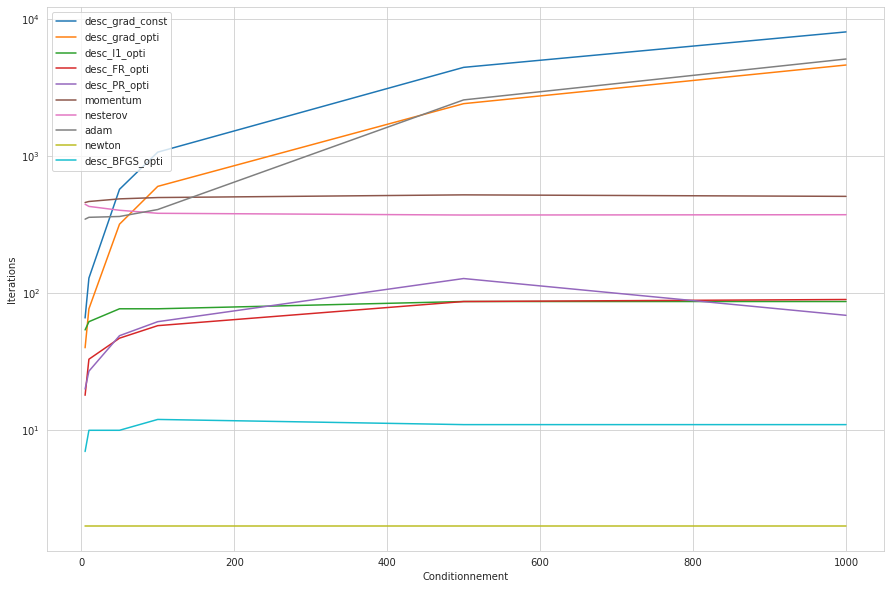

In [116]:
dim=10
conds = [5,10,50,100,500,1000]
systems = [create_system(dim,cond=val) for val in conds]
x_exact=np.zeros(dim)+1.

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam, newton, desc_BFGS_opti)

for method in Liste_method:
    iters = []
    for i in range(len(conds)):
        cond = conds[i]
        A,b = systems[i]
        b=A@x_exact
        
        if method == desc_grad_const:
            res = method(quadraticn_,x0,mu=0.9/cond)
        else:
            res = method(quadraticn_,x0)

        res = np.array(res)
        
        iters.append(len(res))
        
    plt.plot(conds, iters,label=method.__name__)

plt.legend()
plt.xlabel("Conditionnement")
plt.ylabel("Iterations")
plt.yscale("log")

plt.show()

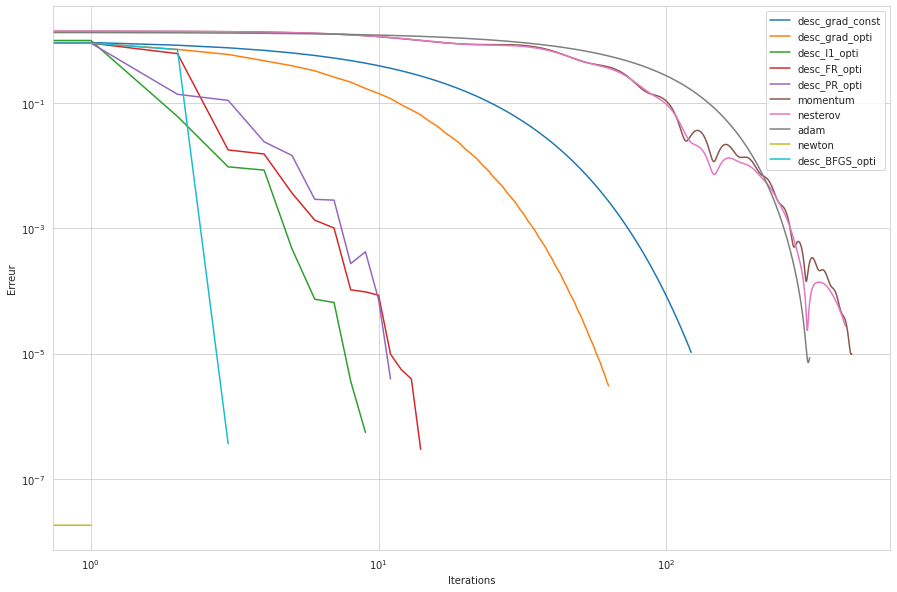

In [117]:
dim=2
cond = 10
x_exact=np.zeros(dim)+1.
A,b = create_system(dim, cond)
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(15,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam, newton, desc_BFGS_opti)
max_iter = -1
for method in Liste_method:
    iters = []
    errors = []
    
    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)

    res = np.array(res)
    errors = [np.linalg.norm(x - x_exact) for x in res]
    iters =  [i for i in range(len(res))]
    plt.plot(iters, errors,label=method.__name__)

plt.legend()
plt.xlabel("Iterations")
plt.xscale("log")
plt.ylabel("Erreur")
plt.yscale("log")
plt.show()

In [115]:
import pandas as pd
import time
pd.set_option('display.max_rows', None)

GD_methods = [desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti, desc_PR_opti, momentum, nesterov, adam, newton, desc_BFGS_opti]
test_methods = [(quadraticn_, [2, 10]), (Rosenbrock, [2])]

df_GD = pd.DataFrame(columns=["method", "dim", "nb_iter", "error", "time"])
it = 0
for f, dims in test_methods:
    for dim in dims:
        x0=np.zeros(dim)
        x_exact=np.zeros(dim)+1.
        f_name = f.__name__
        if f == quadraticn_:
            A,b = create_system(dim,cond=3.)
            b=A@x_exact
        for gd in GD_methods:
            t0 = time.time()
            res = gd(f, x0)
            gd_time = time.time() - t0
            res = np.array(res, dtype=object)
            error = np.linalg.norm(res[-1] - x_exact)
            df_GD.loc[f"{f_name}{it}"] = pd.Series({
                "method": f"{gd.__name__}",
                "dim": dim,
                "nb_iter": len(res),
                "error": error if error < 1E5 else math.inf,
                "time" : gd_time
            })
            it += 1
display(df_GD)

method dim nb_iter     error      time
quadraticn_0   desc_grad_const   2    6960  0.001002  1.149904
quadraticn_1    desc_grad_opti   2      20  0.000001  0.006909
quadraticn_2      desc_l1_opti   2       8  0.000001  0.005652
quadraticn_3      desc_FR_opti   2      11       0.0  0.016756
quadraticn_4      desc_PR_opti   2       9  0.000001   0.03165
quadraticn_5          momentum   2     433  0.000015   0.07924
quadraticn_6          nesterov   2     428  0.000021  0.117577
quadraticn_7              adam   2     336  0.000004  0.076295
quadraticn_8            newton   2       2       0.0  0.009316
quadraticn_9    desc_BFGS_opti   2       4  0.000108  0.026154
quadraticn_10  desc_grad_const  10    7218  0.001063  3.681931
quadraticn_11   desc_grad_opti  10      25  0.000001  0.020069
quadraticn_12     desc_l1_opti  10      65  0.000002  0.057886
quadraticn_13     desc_FR_opti  10      16  0.000001  0.028496
quadraticn_14     desc_PR_opti  10      15  0.000002  0.019604
quadraticn_15         momentum  10     447  0.000034  0.168272
quadraticn_16         nesterov  10     442  0.000024   0.13397
quadraticn_17             adam  10     346  0.000016  0.108639
quadraticn_18           newton  10       2       0.0  0.003951
quadraticn_19   desc_BFGS_opti  10       4  0.391635  0.386236
Rosenbrock20   desc_grad_const   2   10000  0.012517  0.463362
Rosenbrock21    desc_grad_opti   2    7035  0.000977  5.055735
Rosenbrock22      desc_l1_opti   2    4245  0.000764   3.27468
Rosenbrock23      desc_FR_opti   2      32  0.000166   0.01889
Rosenbrock24      desc_PR_opti   2      18  0.000062  0.011694
Rosenbrock25          momentum   2     838  0.000101  0.047698
Rosenbrock26          nesterov   2     857  0.000102  0.052816
Rosenbrock27              adam   2     624  0.000035  0.049591
Rosenbrock28            newton   2       2  1.000002  0.006664
Rosenbrock29    desc_BFGS_opti   2       3  0.913829  0.197849